## Ritmos corticales mu y percepción pasiva de pulso

Análisis de datos de EEG, tarea conductual y Spotify para Trabajo Integrador Final de la Licenciatura en Psicología de la Universidad Favaloro de Francisco Cossavella.

In [153]:
import numpy as np
import os
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.io import loadmat
import mat73
import librosa as lb
import librosa.display

sns.set_context('paper', 
                font_scale=1.5, 
                rc={"lines.linewidth": 1.5},
               )

import warnings
warnings.filterwarnings("ignore")

Acá importo los datos con las features extraídas en matlab

In [154]:
data_time = pd.DataFrame()

for j in range(1, 11):
    for i in range(1, 21):
        d = pd.read_csv(f'song{j}/time_over_std/time_over_std{i}.csv', names=['time'])
        d['song'] = i
        d['subject'] = j
        data_time = pd.concat([data_time, d], ignore_index=True)

In [155]:
data_eeg = pd.DataFrame()
for i in range(1, 11):
    d = pd.read_csv(f'normalized_alpha_song{i}.csv') 
    d['song'] = i
    data_eeg = pd.concat([data_eeg, d], ignore_index=True)

In [156]:
data_eeg.time_over_std = data_time.time

In [157]:
data_eeg.columns = data_eeg.columns.str.capitalize()

In [158]:
data_tapit = pd.read_csv('Tapit_entropy.csv')
data_spotify = pd.read_excel('Spotify_data.xlsx')
data_ratings = mat73.loadmat('behavioralRatings.mat')
data_subjects = loadmat('participantInfo.mat')
data_mir = pd.read_csv('canciones/mir_data.csv')

In [159]:
songs = {1: 'First Fires', 2: 'Oino', 3: 'Tiptoes', 4: 'Careless Love', 5: 'Lebanese Blonde',
         6: 'Canopée', 7: 'Doing Yoga', 8: 'Until the Sun Needs to Rise', 9: 'Silent Shout', 10: 'The Last Thing You Should Do'}

In [160]:
data_eeg['Song'] = data_eeg.Song.map(songs)

In [161]:
data_eeg

Subjects      Area  Electrode  Mean_alpha  Std_alpha  Time_over_std  \
0            1  left_arm         30    0.693739   1.045145       0.057554   
1            1  left_arm         36    0.659253   1.047318       0.046763   
2            1  left_arm         37    0.823279   1.298921       0.035971   
3            1  left_arm         41    0.757750   1.218854       0.064748   
4            1  left_arm         42    0.828434   1.334297       0.043165   
...        ...       ...        ...         ...        ...            ...   
2995        20  leg_area          7    0.700719   1.020966       0.053691   
2996        20  leg_area         31    0.833328   1.208916       0.046980   
2997        20  leg_area         55    0.871362   1.257519       0.050336   
2998        20  leg_area         80    0.908970   1.391944       0.057047   
2999        20  leg_area        106    0.579898   0.830209       0.053691   

                              Song  
0                      First Fires  
1                      First Fires  
2                      First Fires  
3                      First Fires  
4                      First Fires  
...                            ...  
2995  The Last Thing You Should Do  
2996  The Last Thing You Should Do  
2997  The Last Thing You Should Do  
2998  The Last Thing You Should Do  
2999  The Last Thing You Should Do  

[3000 rows x 7 columns]

In [162]:
data_mir.columns = data_mir.columns.str.capitalize()

In [163]:
data_mir.Song = data_mir.Song.str.strip('.wav')

In [164]:
data_eeg.Song.unique()

array(['First Fires', 'Oino', 'Tiptoes', 'Careless Love',
       'Lebanese Blonde', 'Canopée', 'Doing Yoga',
       'Until the Sun Needs to Rise', 'Silent Shout',
       'The Last Thing You Should Do'], dtype=object)

In [165]:
data_mir.replace({'Doing Yog': 'Doing Yoga'}, inplace = True)

In [166]:
data_eeg = pd.merge(data_eeg, data_mir, on = 'Song')

In [167]:
Familiarity = []
Enjoyment = []

for j in data_ratings['behavioralRatings']: 
    for i in j:
        Familiarity.append(int(i[0]))
        Enjoyment.append(int(i[1]))

In [168]:
data_ratings = pd.DataFrame(list(zip(Familiarity, Enjoyment)), columns=['Familiarity', 'Enjoyment'])
data_ratings

Familiarity  Enjoyment
0              1          8
1              1          8
2              1          5
3              1          5
4              9          9
..           ...        ...
195            2          9
196            1          4
197            2          6
198            1          8
199            1          1

[200 rows x 2 columns]

In [169]:
Subject = np.arange(1, 21)
Age = []
Training = []
Listening = []

for j in data_subjects['participantInfo'][0]:
    Age.append(int(j['age'].item()))
    Training.append(int(j['nYearsTraining'].item()))
    Listening.append(int(j['weeklyListening'].item()))

In [170]:
data_subjects = pd.DataFrame(list(zip(Subject, Age, Training, Listening)), columns=['Subject', 'Age', 'Training', 'Listening'])
data_subjects

Subject  Age  Training  Listening
0         1   25         2         28
1         2   18        11          7
2         3   29        24          7
3         4   24         8         21
4         5   22         0          5
5         6   24         4         17
6         7   19         0         31
7         8   23         0         23
8         9   20         1         14
9        10   23        12         28
10       11   23         6          7
11       12   22         6         10
12       13   19         8          3
13       14   24         2          5
14       15   23         2         21
15       16   22         4          7
16       17   22         8          3
17       18   22        17         35
18       19   28        21          7
19       20   28         7          7

In [171]:
data_tapit = data_tapit[['Subject', 'Trial', 'Song', 'Entropy']]

In [172]:
data_tapit

Subject  Trial  Song   Entropy
0          2      1   0.0  1.649425
1          2      2   2.0  1.210470
2          2      3   6.0  1.035342
3          2      4   5.0  0.854784
4          2      5   7.0  0.671740
..       ...    ...   ...       ...
215       23      6   4.0  0.896070
216       23      7   0.0  0.993895
217       23      8   1.0  0.792625
218       23      9   9.0  0.377443
219       23     10   5.0  0.714412

[220 rows x 4 columns]

In [173]:
data_tapit.Subject.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23], dtype=int64)

In [174]:
data_tapit = data_tapit.drop(index = data_tapit[data_tapit.Subject.isin([18, 22])].index)

In [175]:
data_tapit.Subject.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
       20, 21, 23], dtype=int64)

In [176]:
subs = {2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9,
        11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 19: 17, 20: 18, 21: 19, 23: 20}

In [177]:
data_tapit['Subject'] = data_tapit.Subject.map(subs)

In [178]:
data_tapit['Song'] = data_tapit['Song'].astype(int)

In [179]:
data_tapit.Song.unique()

array([0, 2, 6, 5, 7, 8, 1, 3, 9, 4])

In [180]:
data_tapit['Song'] = data_tapit.Song.map({0: 'First Fires', 1: 'Oino', 2: 'Tiptoes', 3: 'Careless Love', 4: 'Lebanese Blonde',
                                                    5: 'Canopée', 6: 'Doing Yoga', 7: 'Until the Sun Needs to Rise', 8: 'Silent Shout', 9: 'The Last Thing You Should Do'})

In [181]:
data_tapit

Subject  Trial                          Song   Entropy
0          1      1                   First Fires  1.649425
1          1      2                       Tiptoes  1.210470
2          1      3                    Doing Yoga  1.035342
3          1      4                       Canopée  0.854784
4          1      5   Until the Sun Needs to Rise  0.671740
..       ...    ...                           ...       ...
215       20      6               Lebanese Blonde  0.896070
216       20      7                   First Fires  0.993895
217       20      8                          Oino  0.792625
218       20      9  The Last Thing You Should Do  0.377443
219       20     10                       Canopée  0.714412

[200 rows x 4 columns]

In [182]:
data_tapit.Song.unique()

array(['First Fires', 'Tiptoes', 'Doing Yoga', 'Canopée',
       'Until the Sun Needs to Rise', 'Silent Shout', 'Oino',
       'Careless Love', 'The Last Thing You Should Do', 'Lebanese Blonde'],
      dtype=object)

In [183]:
data_ratings.shape

(200, 2)

In [184]:
data_tapit.shape

(200, 4)

In [185]:
data_tapit = pd.concat([data_tapit.reset_index(), data_ratings], axis=1)

In [186]:
data_spotify

Song                Artist  Length  Popularity  \
0                   First Fires                Bonobo  4m 38s          45   
1                          Oino             LA Priest  4m 31s          45   
2                       Tiptoes  Two Door Cinema Club  3m 34s          34   
3                 Careless Love          Croquet Club  4m 54s          35   
4               Lebanese Blonde  Thievery Corporation  4m 48s          50   
5                       Canopée            Polo & Pan  4m 36s          66   
6                    Doing Yoga          Kazy Lambist  4m 51s          53   
7   Until the Sun Needs to Rise          RÜFÜS DU SOL  4m 52s          53   
8                  Silent Shout             The Knife  4m 55s          37   
9  The Last Thing You Should Do           David Bowie  4m 57s          23   

                      Added Explicit  Acousticness  Danceability  Energy  \
0  April 6, 2022 at 4:26 PM       no            39            61      41   
1  April 6, 2022 at 4:26 PM       no            26            76      72   
2  April 6, 2022 at 4:27 PM       no             1            55      67   
3  April 6, 2022 at 4:27 PM       no            98            64      26   
4  April 6, 2022 at 4:27 PM       no            24            81      84   
5  April 6, 2022 at 4:27 PM       no             9            70      69   
6  April 6, 2022 at 4:27 PM       no            21            73      76   
7  April 6, 2022 at 4:28 PM       no             1            73      69   
8  April 6, 2022 at 4:28 PM       no            10            60      70   
9  April 6, 2022 at 4:28 PM       no             0            48     100   

   Liveness  Loudness Key   Mode  Speachiness  Instrumentalness  Tempo  \
0        44     -10.5  G#  major            4                29    110   
1         9      -6.6  G#  minor            5                48    139   
2         9      -5.7   D  major            4                 0    134   
3         9     -14.9   A  minor            6                68     82   
4         6      -6.6   A  minor            5                86     92   
5         9      -6.6   F  minor            3                 1     96   
6        39      -6.8   E  minor            9                 0    109   
7         9      -8.0  G#  major            3                29    120   
8        10     -10.5   B  minor            4                90    129   
9         4      -4.6   A  minor           14                69    150   

   Time signature  Happiness  
0               4         21  
1               4         96  
2               4         56  
3               4         60  
4               4         65  
5               4         37  
6               4         32  
7               4         12  
8               4         39  
9               4         37

In [187]:
data_spotify.Song

0                     First Fires
1                            Oino
2                         Tiptoes
3                   Careless Love
4                 Lebanese Blonde
5                         Canopée
6                      Doing Yoga
7     Until the Sun Needs to Rise
8                    Silent Shout
9    The Last Thing You Should Do
Name: Song, dtype: object

In [188]:
data = pd.merge(data_tapit, data_spotify, on='Song')
data

index  Subject  Trial             Song   Entropy  Familiarity  Enjoyment  \
0        0        1      1      First Fires  1.649425            1          8   
1       12        2      3      First Fires  1.204062            1          7   
2       28        3      9      First Fires  1.557907            1          7   
3       36        4      7      First Fires  0.850097            1          7   
4       42        5      3      First Fires  1.627679            1          6   
..     ...      ...    ...              ...       ...          ...        ...   
195    151       16      2  Lebanese Blonde  2.132277            1          5   
196    176       17      7  Lebanese Blonde  0.928342            1          4   
197    183       18      4  Lebanese Blonde  1.392355            6          9   
198    195       19      6  Lebanese Blonde  0.886162            1          8   
199    215       20      6  Lebanese Blonde  0.896070            2          9   

                   Artist  Length  Popularity  ... Energy Liveness  Loudness  \
0                  Bonobo  4m 38s          45  ...     41       44     -10.5   
1                  Bonobo  4m 38s          45  ...     41       44     -10.5   
2                  Bonobo  4m 38s          45  ...     41       44     -10.5   
3                  Bonobo  4m 38s          45  ...     41       44     -10.5   
4                  Bonobo  4m 38s          45  ...     41       44     -10.5   
..                    ...     ...         ...  ...    ...      ...       ...   
195  Thievery Corporation  4m 48s          50  ...     84        6      -6.6   
196  Thievery Corporation  4m 48s          50  ...     84        6      -6.6   
197  Thievery Corporation  4m 48s          50  ...     84        6      -6.6   
198  Thievery Corporation  4m 48s          50  ...     84        6      -6.6   
199  Thievery Corporation  4m 48s          50  ...     84        6      -6.6   

     Key   Mode  Speachiness  Instrumentalness Tempo Time signature  Happiness  
0     G#  major            4                29   110              4         21  
1     G#  major            4                29   110              4         21  
2     G#  major            4                29   110              4         21  
3     G#  major            4                29   110              4         21  
4     G#  major            4                29   110              4         21  
..   ...    ...          ...               ...   ...            ...        ...  
195    A  minor            5                86    92              4         65  
196    A  minor            5                86    92              4         65  
197    A  minor            5                86    92              4         65  
198    A  minor            5                86    92              4         65  
199    A  minor            5                86    92              4         65  

[200 rows x 24 columns]

In [189]:
data_eeg

Subjects      Area  Electrode  Mean_alpha  Std_alpha  Time_over_std  \
0            1  left_arm         30    0.693739   1.045145       0.057554   
1            1  left_arm         36    0.659253   1.047318       0.046763   
2            1  left_arm         37    0.823279   1.298921       0.035971   
3            1  left_arm         41    0.757750   1.218854       0.064748   
4            1  left_arm         42    0.828434   1.334297       0.043165   
...        ...       ...        ...         ...        ...            ...   
2995        20  leg_area          7    0.700719   1.020966       0.053691   
2996        20  leg_area         31    0.833328   1.208916       0.046980   
2997        20  leg_area         55    0.871362   1.257519       0.050336   
2998        20  leg_area         80    0.908970   1.391944       0.057047   
2999        20  leg_area        106    0.579898   0.830209       0.053691   

                              Song  Event_density  Pulse_clarity   Zero_cross  \
0                      First Fires       0.838830       0.357434   944.395155   
1                      First Fires       0.838830       0.357434   944.395155   
2                      First Fires       0.838830       0.357434   944.395155   
3                      First Fires       0.838830       0.357434   944.395155   
4                      First Fires       0.838830       0.357434   944.395155   
...                            ...            ...            ...          ...   
2995  The Last Thing You Should Do       5.154639       0.547609  2461.557678   
2996  The Last Thing You Should Do       5.154639       0.547609  2461.557678   
2997  The Last Thing You Should Do       5.154639       0.547609  2461.557678   
2998  The Last Thing You Should Do       5.154639       0.547609  2461.557678   
2999  The Last Thing You Should Do       5.154639       0.547609  2461.557678   

           Rolloff  Brightness  Regularity  Mir_entropy  
0      6107.112908    0.477065    0.596355     0.903008  
1      6107.112908    0.477065    0.596355     0.903008  
2      6107.112908    0.477065    0.596355     0.903008  
3      6107.112908    0.477065    0.596355     0.903008  
4      6107.112908    0.477065    0.596355     0.903008  
...            ...         ...         ...          ...  
2995  11201.576471    0.679779    0.209841     0.955768  
2996  11201.576471    0.679779    0.209841     0.955768  
2997  11201.576471    0.679779    0.209841     0.955768  
2998  11201.576471    0.679779    0.209841     0.955768  
2999  11201.576471    0.679779    0.209841     0.955768  

[3000 rows x 14 columns]

In [190]:
data = pd.merge(data, data_eeg, left_on=['Subject', 'Song'], right_on=['Subjects', 'Song'])

In [191]:
data = data.merge(data_subjects, on='Subject')

In [192]:
data.isna().mean()

index               0.0
Subject             0.0
Trial               0.0
Song                0.0
Entropy             0.0
Familiarity         0.0
Enjoyment           0.0
Artist              0.0
Length              0.0
Popularity          0.0
Added               0.0
Explicit            0.0
Acousticness        0.0
Danceability        0.0
Energy              0.0
Liveness            0.0
Loudness            0.0
Key                 0.0
Mode                0.0
Speachiness         0.0
Instrumentalness    0.0
Tempo               0.0
Time signature      0.0
Happiness           0.0
Subjects            0.0
Area                0.0
Electrode           0.0
Mean_alpha          0.0
Std_alpha           0.0
Time_over_std       0.0
Event_density       0.0
Pulse_clarity       0.0
Zero_cross          0.0
Rolloff             0.0
Brightness          0.0
Regularity          0.0
Mir_entropy         0.0
Age                 0.0
Training            0.0
Listening           0.0
dtype: float64

In [193]:
data = data.drop(columns=['index', 'Added'])
data = data.loc[:,~data.columns.duplicated()].copy()

In [194]:
data.describe()

Subject       Trial      Entropy  Familiarity    Enjoyment  \
count  3000.000000  3000.00000  3000.000000  3000.000000  3000.000000   
mean     10.500000     5.50000     1.109162     1.380000     5.650000   
std       5.767243     2.87276     0.403821     1.402232     1.977069   
min       1.000000     1.00000     0.377443     1.000000     1.000000   
25%       5.750000     3.00000     0.815536     1.000000     4.000000   
50%      10.500000     5.50000     0.965842     1.000000     6.000000   
75%      15.250000     8.00000     1.374298     1.000000     7.000000   
max      20.000000    10.00000     2.427834     9.000000     9.000000   

        Popularity  Acousticness  Danceability       Energy     Liveness  ...  \
count  3000.000000   3000.000000   3000.000000  3000.000000  3000.000000  ...   
mean     44.100000     22.900000     66.100000    67.400000    14.800000  ...   
std      11.641958     27.855855      9.742774    19.640993    13.506325  ...   
min      23.000000      0.000000     48.000000    26.000000     4.000000  ...   
25%      35.000000      1.000000     60.000000    67.000000     9.000000  ...   
50%      45.000000     15.500000     67.000000    69.500000     9.000000  ...   
75%      53.000000     26.000000     73.000000    76.000000    10.000000  ...   
max      66.000000     98.000000     81.000000   100.000000    44.000000  ...   

       Event_density  Pulse_clarity   Zero_cross       Rolloff   Brightness  \
count    3000.000000    3000.000000  3000.000000   3000.000000  3000.000000   
mean        2.882772       0.556846  1171.400295   7639.292836     0.465405   
std         1.231017       0.116813   493.289469   2381.371102     0.100311   
min         0.838830       0.357434   704.432240   3642.323434     0.279355   
25%         1.878397       0.441749   809.842983   5879.652679     0.401604   
50%         3.067450       0.557260  1040.728496   7594.465292     0.477401   
75%         3.713864       0.625605  1334.515899   9626.330137     0.503781   
max         5.154639       0.781759  2461.557678  11201.576471     0.679779   

        Regularity  Mir_entropy          Age     Training    Listening  
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000  
mean      0.453339     0.906733    23.000000     7.150000    14.300000  
std       0.206813     0.025079     2.864042     6.733692    10.057023  
min       0.209841     0.857735    18.000000     0.000000     3.000000  
25%       0.258419     0.889563    22.000000     2.000000     7.000000  
50%       0.430202     0.905989    23.000000     6.000000     8.500000  
75%       0.596355     0.922844    24.000000     8.750000    21.500000  
max       0.861161     0.955768    29.000000    24.000000    35.000000  

[8 rows x 31 columns]

In [195]:
def violinplot(var1, var2):
    x = data[[var1, var2]]
    fig, ax = plt.subplots(figsize=(20, 8));
    flierprops = dict(marker = 'o', color='#5c359a')
    sns.violinplot(x = var1, y = var2, data = x, flierprops=flierprops, palette='Spectral', alpha=.6);
    ax = sns.stripplot(x = var1, y = var2, data = data, color="orange", jitter=0.2, size=2.5)

    plt.title(f'{var2} por {var1}')#, fontsize = 16)
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 10)
    plt.xticks(rotation=90)
    plt.xlabel(f"{var1}") #fontsize = 15)
    plt.ylabel(f'{var2}') #fontsize = 15)

## Análisis de normalidad

Primero ploteo y uso test de normalidad de Shapiro para las variables que quiero usar para la correlación para evaluar normalidad.

Entropía: ShapiroResult(statistic=0.9148939251899719, pvalue=3.947623407481493e-38)
Potencia media: ShapiroResult(statistic=0.9238312244415283, pvalue=1.537381629841634e-36)
Desvío: ShapiroResult(statistic=0.9337714910507202, pvalue=1.3836587883185678e-34)
% de tiempo: ShapiroResult(statistic=0.9954483509063721, pvalue=5.796255564405328e-08)


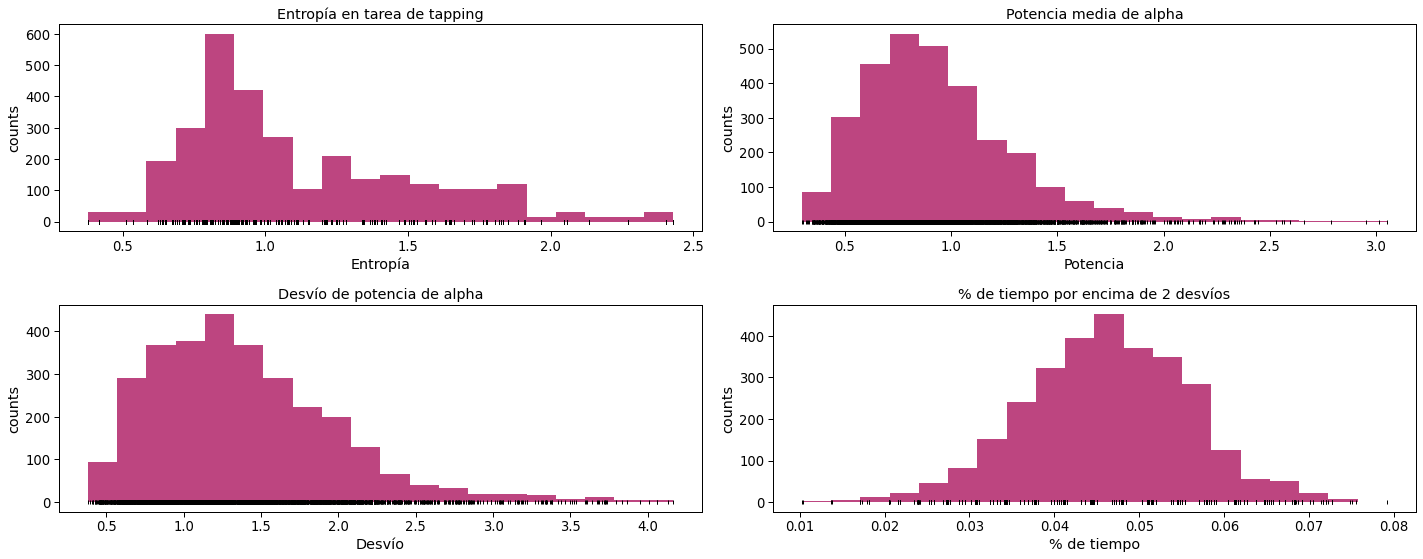

In [196]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 8)) 

axs[0, 0].hist(x=data.Entropy, bins=20, color='#ad1760', alpha=0.8)
axs[0, 0].plot(data.Entropy, np.full_like(data.Entropy, -0.01), '|k', markeredgewidth=1)
axs[0, 0].set_title('Entropía en tarea de tapping')
axs[0, 0].set_xlabel('Entropía')
axs[0, 0].set_ylabel('counts')

axs[0, 1].hist(x=data.Mean_alpha, bins=20, color='#ad1760', alpha=0.8)
axs[0, 1].plot(data.Mean_alpha, np.full_like(data.Mean_alpha, -0.01), '|k', markeredgewidth=1)
axs[0, 1].set_title('Potencia media de alpha')
axs[0, 1].set_xlabel('Potencia')
axs[0, 1].set_ylabel('counts')

axs[1, 0].hist(x=data.Std_alpha, bins=20, color='#ad1760', alpha=0.8)
axs[1, 0].plot(data.Std_alpha, np.full_like(data.Std_alpha, -0.01), '|k', markeredgewidth=1)
axs[1, 0].set_title('Desvío de potencia de alpha')
axs[1, 0].set_xlabel('Desvío')
axs[1, 0].set_ylabel('counts')

axs[1, 1].hist(x=data.Time_over_std, bins=20, color='#ad1760', alpha=0.8)
axs[1, 1].plot(data.Time_over_std, np.full_like(data.Time_over_std, -0.01), '|k', markeredgewidth=1)
axs[1, 1].set_title('% de tiempo por encima de 2 desvíos')
axs[1, 1].set_xlabel('% de tiempo')
axs[1, 1].set_ylabel('counts')

plt.tight_layout()

print(f'Entropía:', stats.shapiro(data.Entropy))
print(f'Potencia media:', stats.shapiro(data.Mean_alpha))
print(f'Desvío:', stats.shapiro(data.Std_alpha))
print(f'% de tiempo:', stats.shapiro(data.Time_over_std))

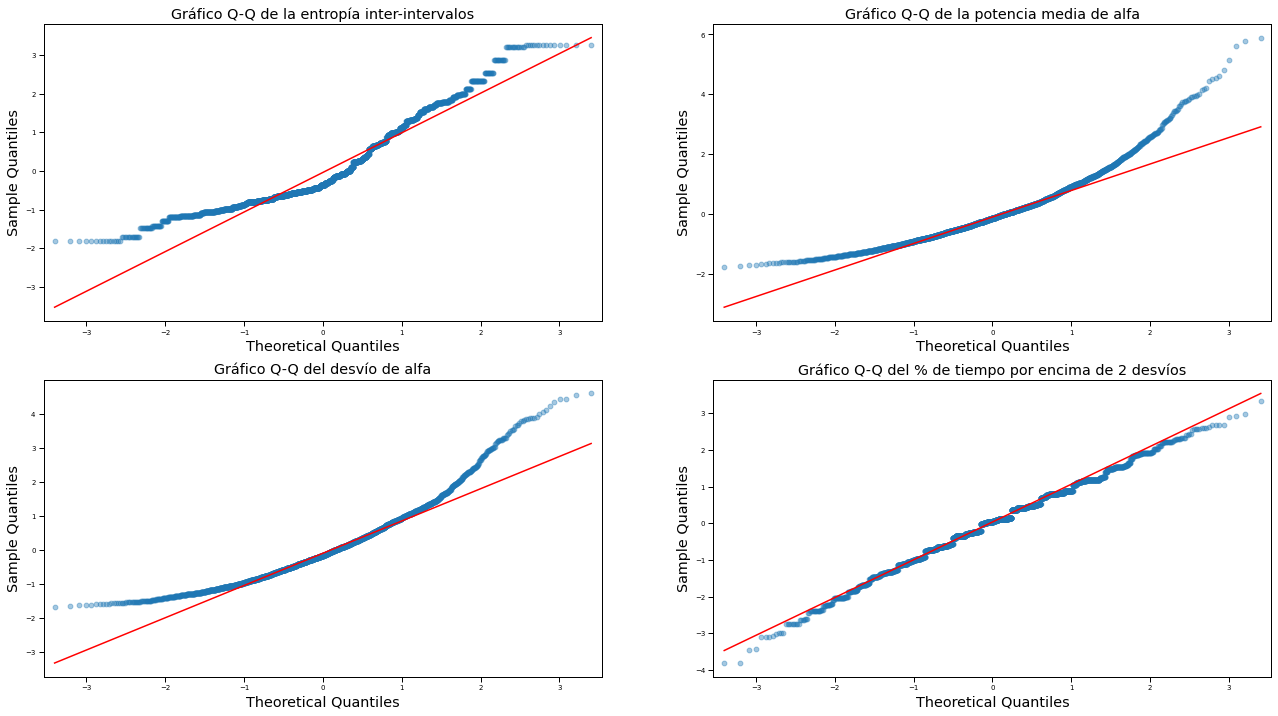

In [197]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(22, 12))

sm.qqplot(
            data.Entropy,
            fit   = True,
            line  = 'q',
            alpha = 0.4,
            lw    = 2,
            ax = ax[0, 0])

ax[0, 0].set_title('Gráfico Q-Q de la entropía inter-intervalos')
ax[0, 0].tick_params(labelsize = 7)

sm.qqplot(
            data.Mean_alpha,
            fit   = True,
            line  = 'q',
            alpha = 0.4,
            lw    = 2,
            ax = ax[0, 1])

ax[0, 1].set_title('Gráfico Q-Q de la potencia media de alfa')
ax[0, 1].tick_params(labelsize = 7)

sm.qqplot(
            data.Std_alpha,
            fit   = True,
            line  = 'q',
            alpha = 0.4,
            lw    = 2,
            ax = ax[1, 0])

ax[1, 0].set_title('Gráfico Q-Q del desvío de alfa')
ax[1, 0].tick_params(labelsize = 7)

sm.qqplot(
            data.Time_over_std,
            fit   = True,
            line  = 'q',
            alpha = 0.4,
            lw    = 2,
            ax = ax[1, 1])

ax[1, 1].set_title('Gráfico Q-Q del % de tiempo por encima de 2 desvíos')
ax[1, 1].tick_params(labelsize = 7)

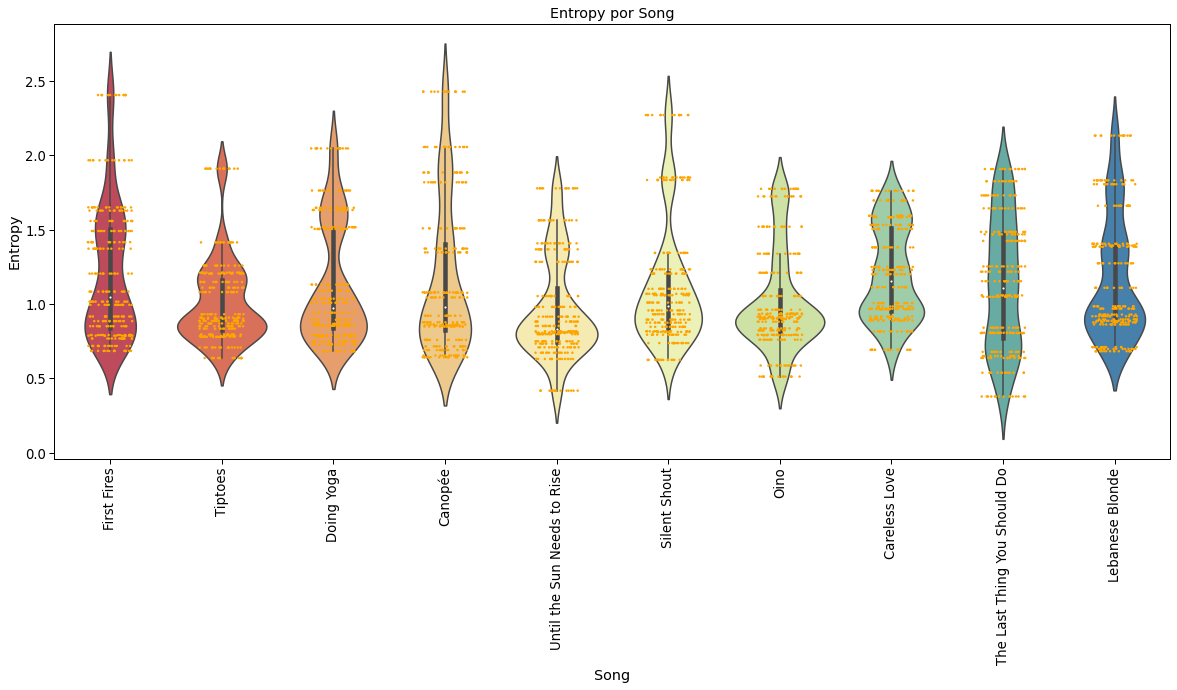

In [198]:
violinplot('Song', 'Entropy')

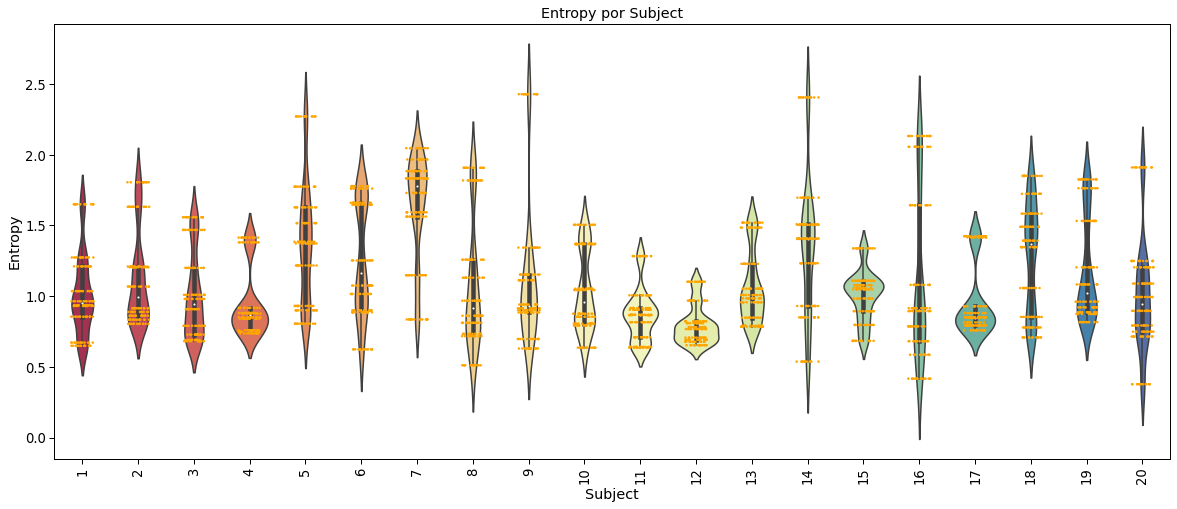

In [199]:
violinplot('Subject', 'Entropy')

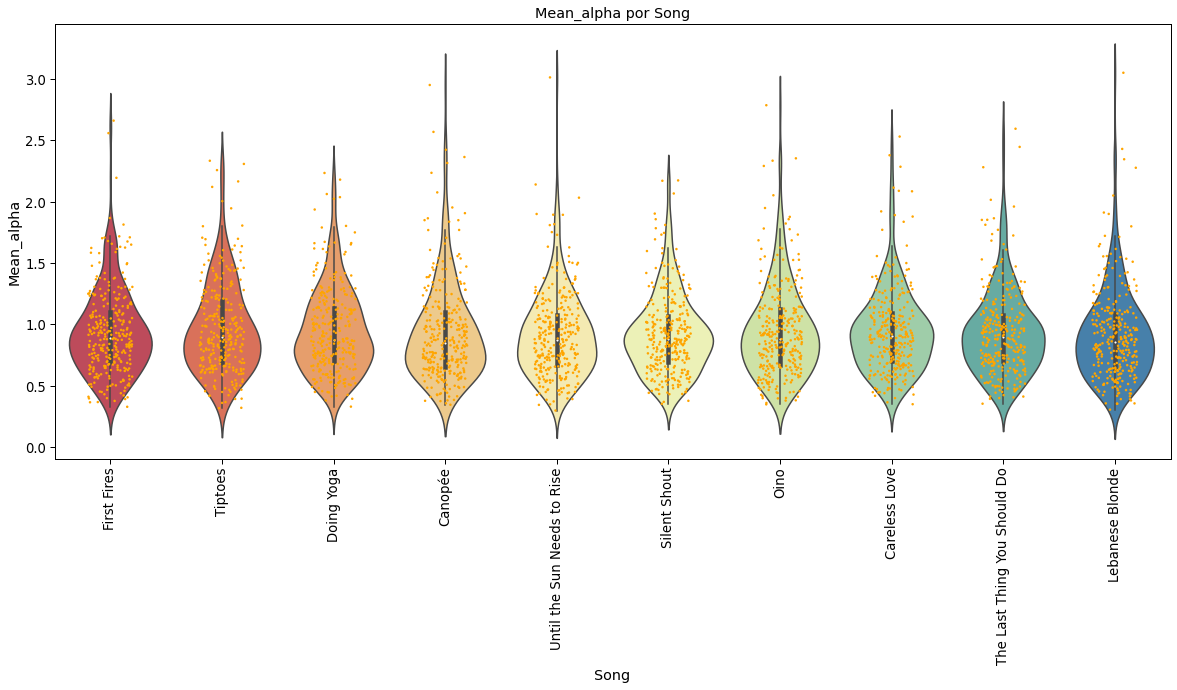

In [200]:
violinplot('Song', 'Mean_alpha')

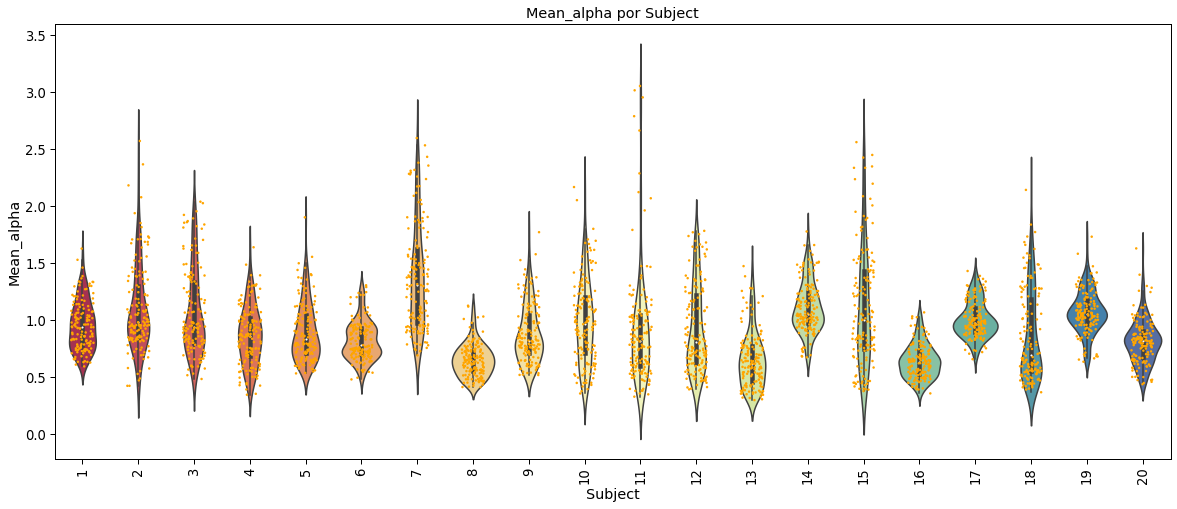

In [201]:
violinplot('Subject', 'Mean_alpha')

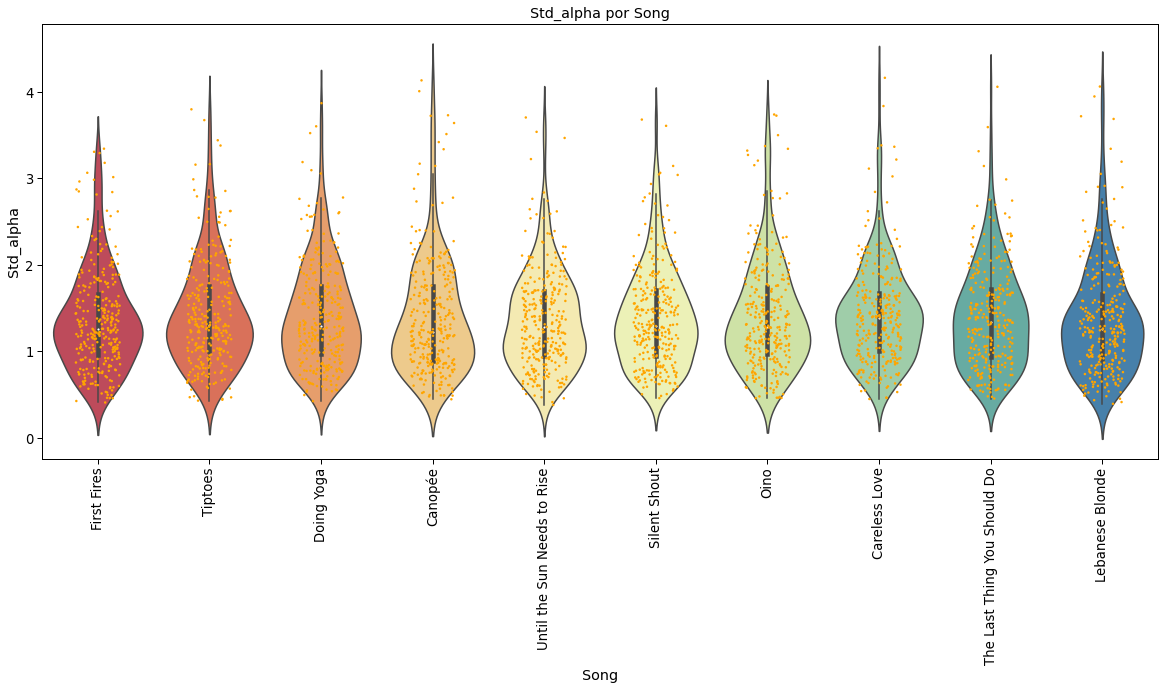

In [202]:
violinplot('Song', 'Std_alpha')

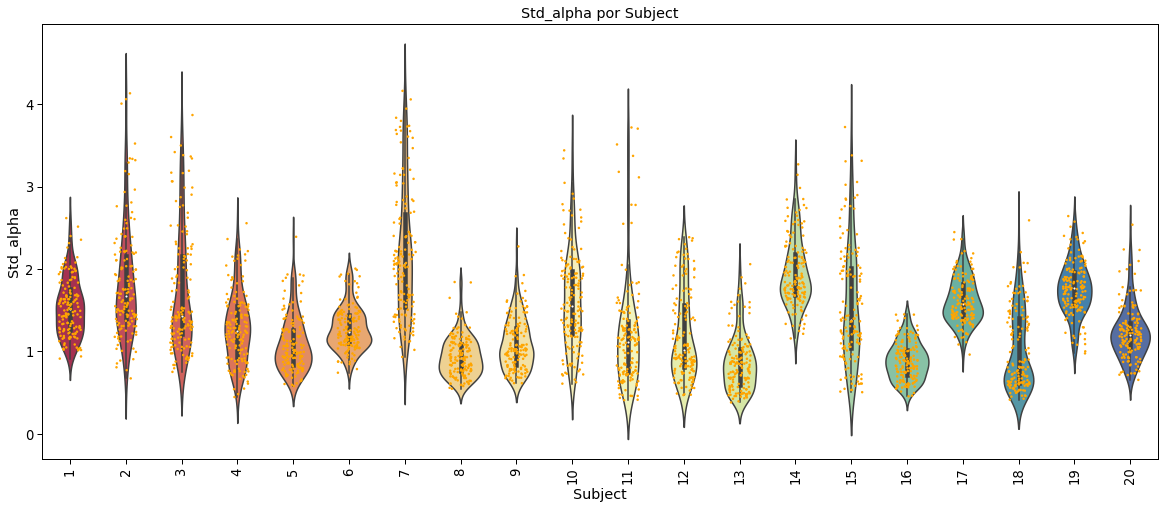

In [203]:
violinplot('Subject', 'Std_alpha')

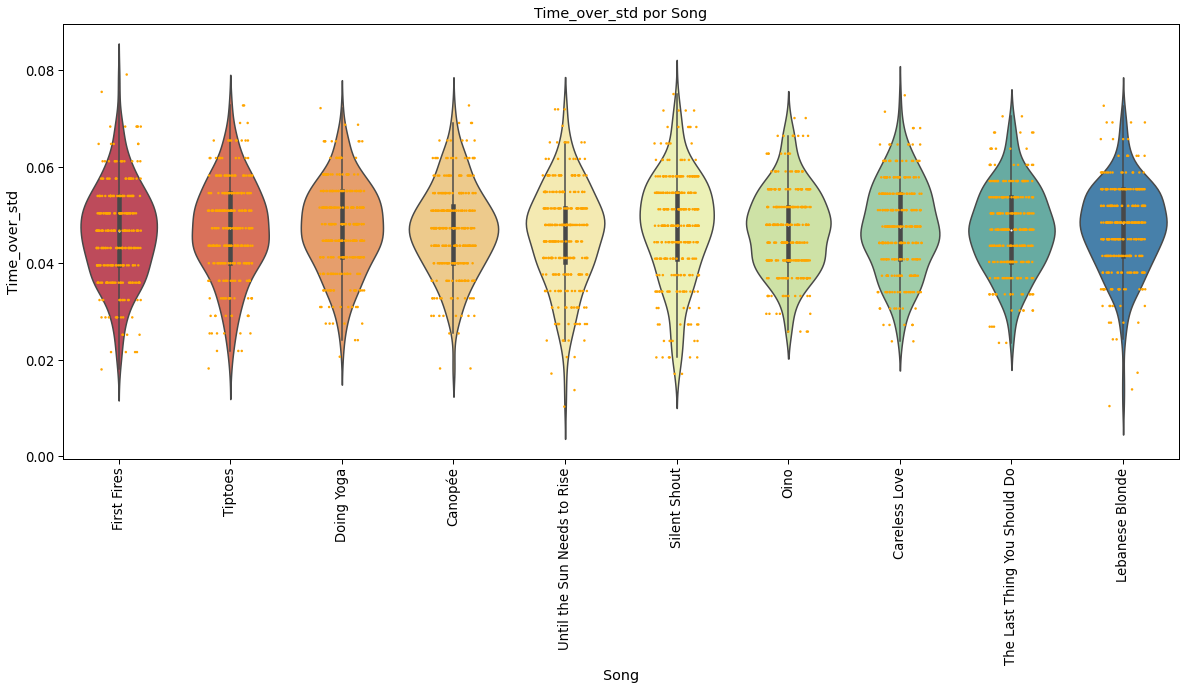

In [204]:
violinplot('Song', 'Time_over_std')

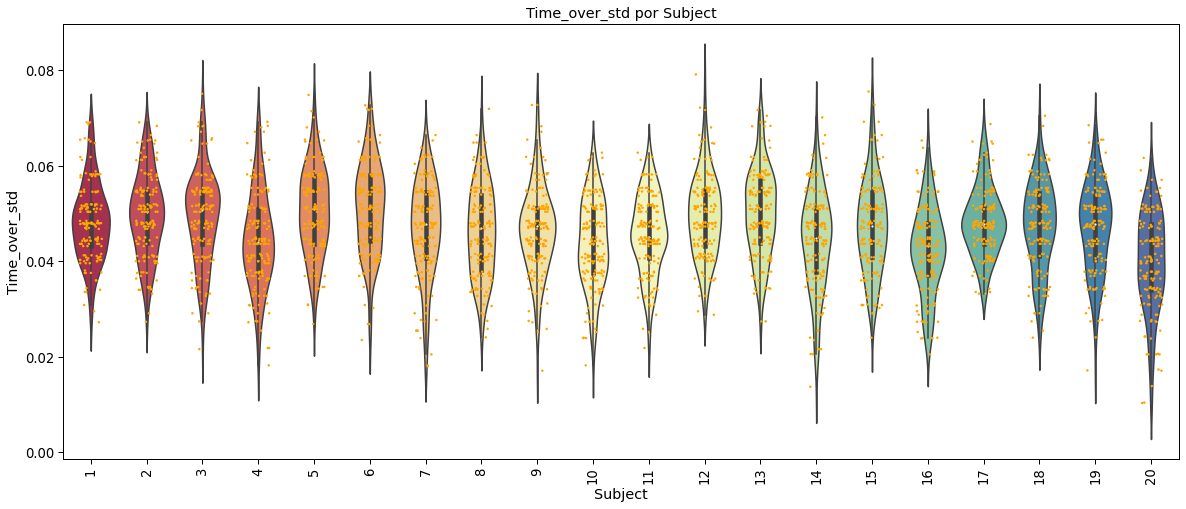

In [205]:
violinplot('Subject', 'Time_over_std')

Enjoyment: ShapiroResult(statistic=0.9573681950569153, pvalue=8.508754281331055e-29)
Familiarity: ShapiroResult(statistic=0.29661357402801514, pvalue=0.0)
Training: ShapiroResult(statistic=0.8584645390510559, pvalue=1.401298464324817e-45)


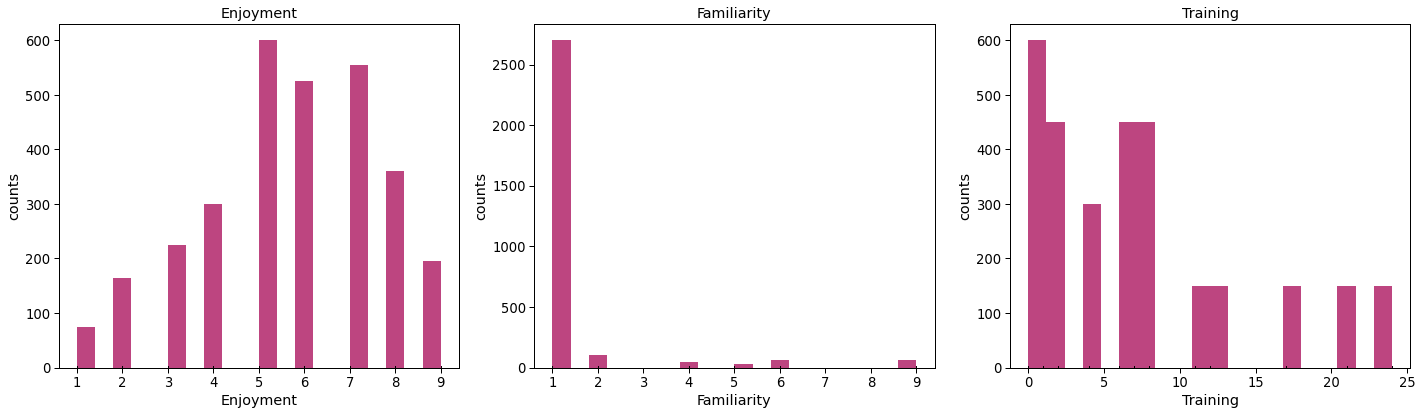

In [284]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6)) 

axs[0].hist(x=data.Enjoyment, bins=20, color='#ad1760', alpha=0.8)
axs[0].plot(data.Enjoyment, np.full_like(data.Enjoyment, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Enjoyment')
axs[0].set_xlabel('Enjoyment')
axs[0].set_ylabel('counts')

axs[1].hist(x=data.Familiarity, bins=20, color='#ad1760', alpha=0.8)
axs[1].plot(data.Familiarity, np.full_like(data.Familiarity, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Familiarity')
axs[1].set_xlabel('Familiarity')
axs[1].set_ylabel('counts')

axs[2].hist(x=data.Training, bins=20, color='#ad1760', alpha=0.8)
axs[2].plot(data.Training, np.full_like(data.Training, -0.01), '|k', markeredgewidth=1)
axs[2].set_title('Training')
axs[2].set_xlabel('Training')
axs[2].set_ylabel('counts')

plt.tight_layout();

print(f'Enjoyment:', stats.shapiro(data.Enjoyment))
print(f'Familiarity:', stats.shapiro(data.Familiarity))
print(f'Training:', stats.shapiro(data.Training))

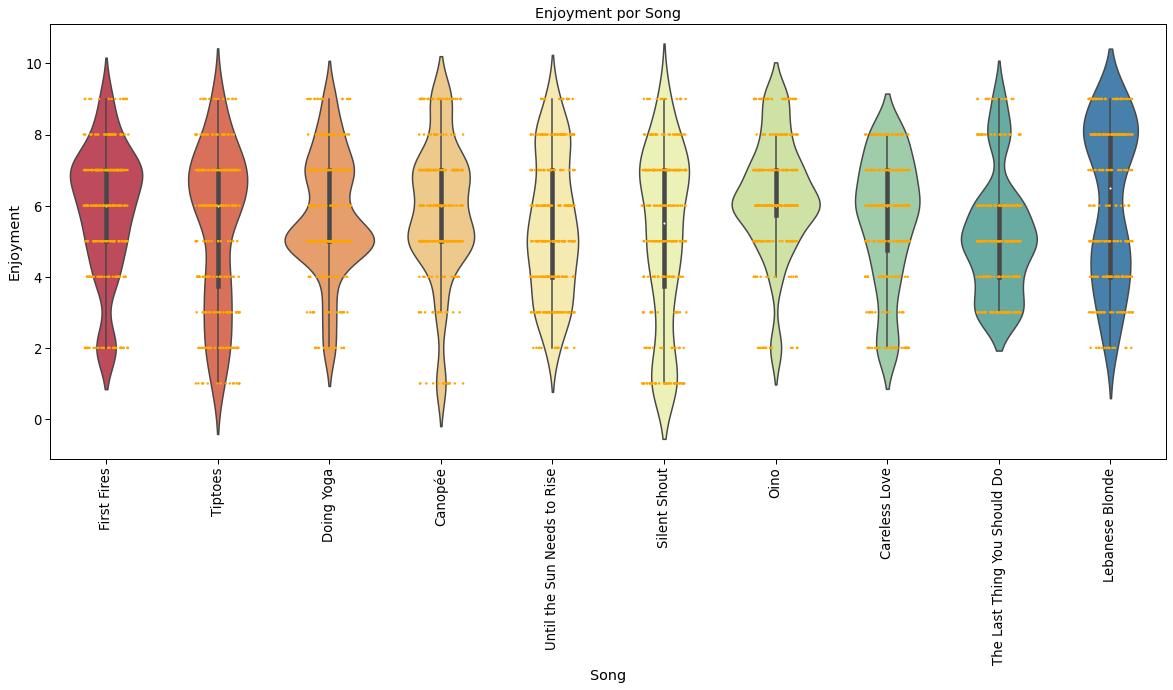

In [207]:
violinplot('Song', 'Enjoyment')

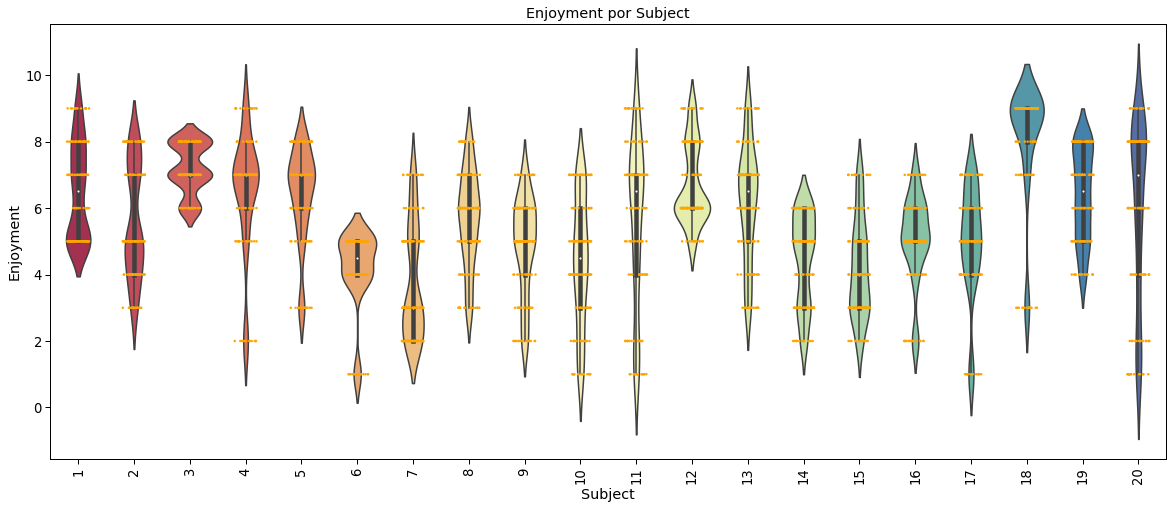

In [208]:
violinplot('Subject', 'Enjoyment')

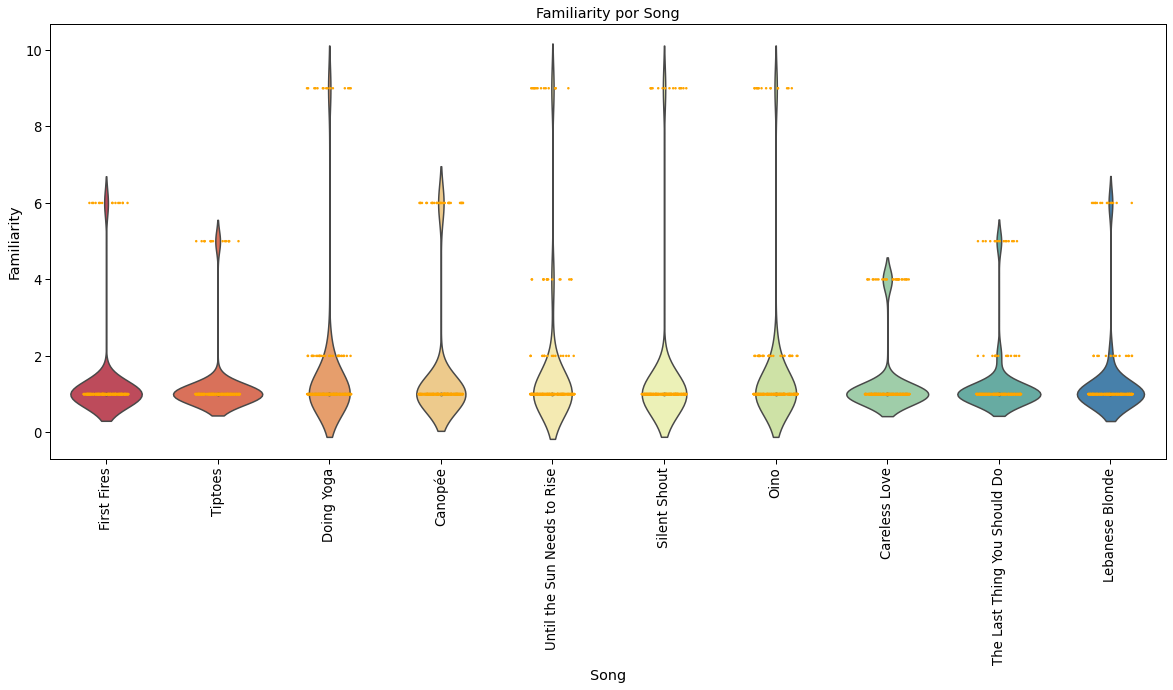

In [209]:
violinplot('Song', 'Familiarity')

Queda más que claro que no tengo nada distribuido normalmente salvo la variable de tiempo, así que voy a tener que usar Spearman.

### Análisis global de asociación entre variables de EEG y tapping

Lo primero que quiero probar es si hay correlaciones significativas entre las variables sin estratificar por ninguna otra variable como sujeto, canción, etc.

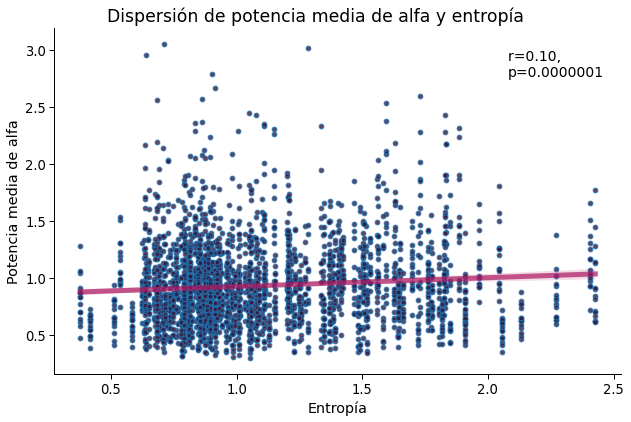

In [210]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha', 
               data = data, 
               height = 6,
               aspect = 1.5,
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.7f}'.format(r, p),
            transform=ax.transAxes, fontsize=14)
    

g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Dispersión de potencia media de alfa y entropía')
g.ax.set_xlabel('Entropía')
g.ax.set_ylabel('Potencia media de alfa')
g.savefig('Media de potencia y entropia.png');
plt.show();

Obviamente, para cada valor de entropía tengo muchos de potencia media de alfa, va a pasar lo mismo con el desvío. 

Voy a crear una variable con la potencia media para cada sujeto y cada canción y otra igual para el desvío, así tengo la misma cantidad de puntos para entropía y para los scores de potencia media y desvío.

In [211]:
data[['Mean_alpha_by_song_sub', 'Mean_std_alpha_by_song_sub']] = data.groupby(['Song', 'Subject'])[['Mean_alpha', 'Std_alpha']].transform('mean')

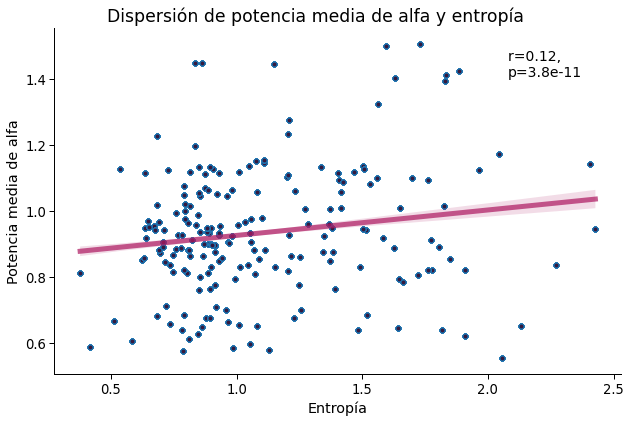

In [212]:
g = sns.lmplot(x = 'Entropy', 
               y = 'Mean_alpha_by_song_sub', 
               data = data, 
               height = 6,
               aspect = 1.5,
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=14)
    

g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Dispersión de potencia media de alfa y entropía')
g.ax.set_xlabel('Entropía')
g.ax.set_ylabel('Potencia media de alfa')
g.savefig('Media de potencia y entropia.png');
plt.show();

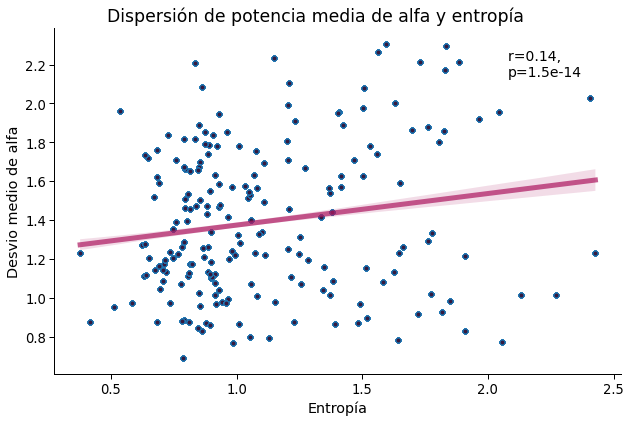

In [213]:
g = sns.lmplot(x = 'Entropy', 
               y = 'Mean_std_alpha_by_song_sub', 
               data = data, 
               height = 6,
               aspect = 1.5,
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=14)
    

g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Dispersión de potencia media de alfa y entropía')
g.ax.set_xlabel('Entropía')
g.ax.set_ylabel('Desvio medio de alfa')
g.savefig('Desvío de potencia y entropia.png');
plt.show();

No dan mucho mejor, pero se ven más coherentes.

Lo que se ve es que claramente, las medidas de la media de potencia y el desvío tienen algún tipo de asociación ya a nivel global, que aunque débil es significativa. 
<br>
A su vez, la medida de % de tiempo por encima de 2 desvíos no está asociada a este nivel.


## Análisis estratificado


Ahora quiero ver qué pasa si en lugar de asociar variables globalmente, lo voy a haciendo agrupando en función de otras variables que pueden estar interviniendo.

En principio, empiezo por ROI.

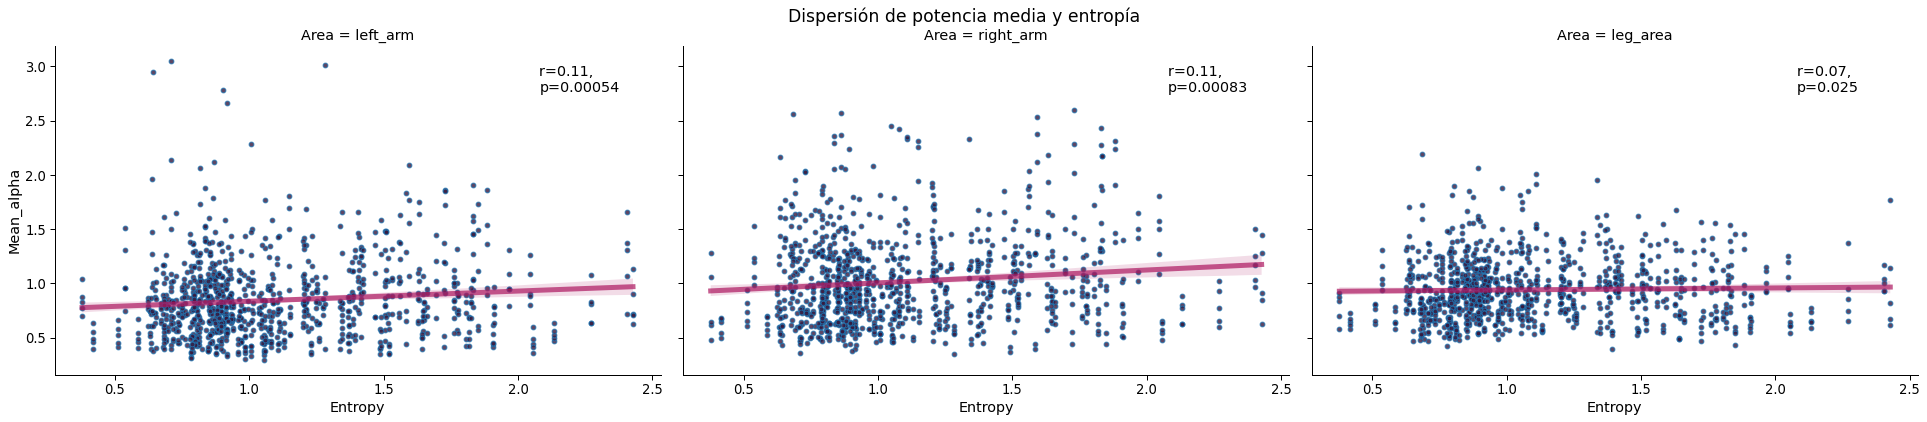

In [214]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha', 
               data = data,
               height = 6,
               aspect = 1.5,
               #row = 'Song',
               col = 'Area',
               #hue = 'Song',
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

De nuevo, para los análisis que haga estratificando por ROI, voy a crear una variable de potencia media y desvío para cada ROI de cada sujeto en cada canción para tener la misma cantidad de puntos.

In [215]:
data[['Mean_alpha_by_area', 'Mean_std_alpha_by_area']] = data.groupby(['Subject', 'Song', 'Area'])[['Mean_alpha', 'Std_alpha']].transform('mean')

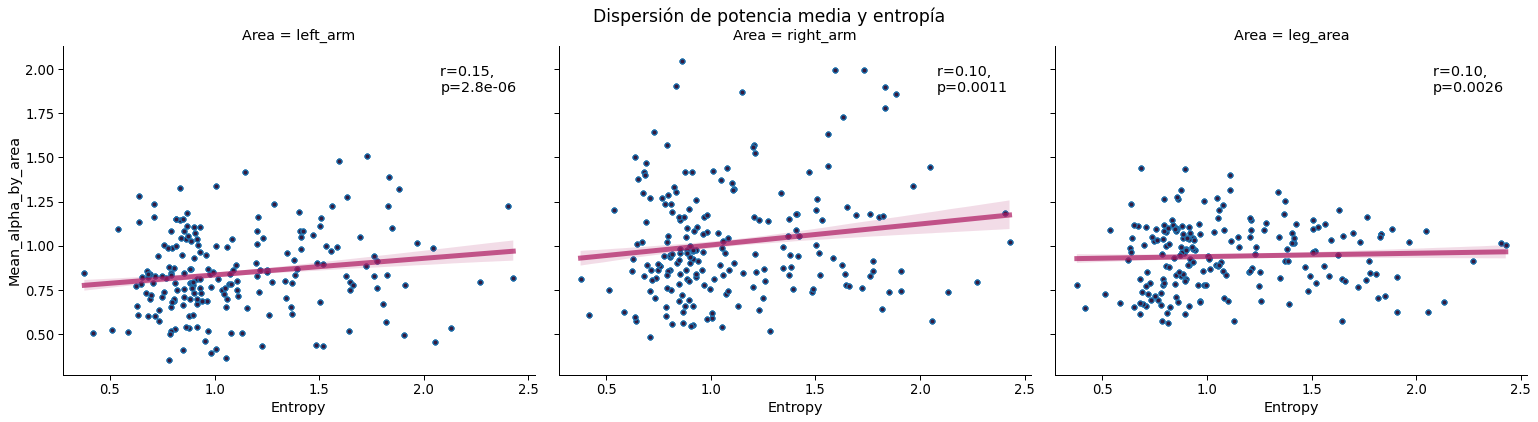

In [216]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Area',
               #hue = 'Song',
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

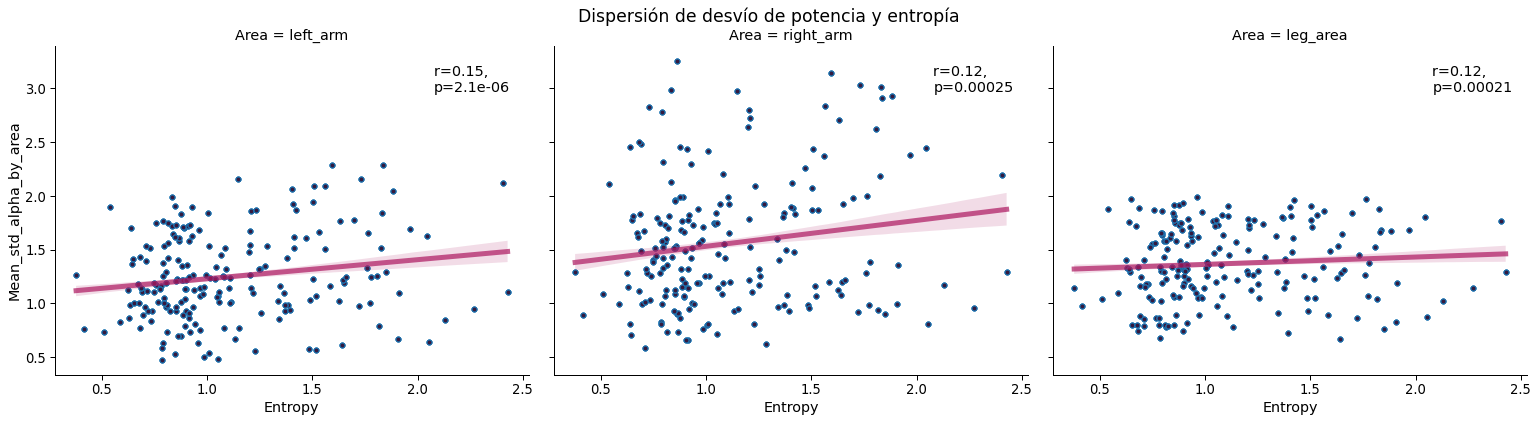

In [217]:
g = sns.lmplot(x = 'Entropy', 
               y = 'Mean_std_alpha_by_area', 
               data = data,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Area',
               #hue = 'Song',
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_area'])
    ax = plt.gca()
    ax.text(.8, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Dispersión de desvío de potencia y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

Ahí se ven más limpias las relaciones, siguen siendo bastante marginales pero significativas.

Lo que voy a hacer es tomar las columnas que tienen datos de los sujetos y quitarles los outliers para poder seguir analizando.

## Analisis sin outliers

Remuevo puntajes que esten a mas de 2 desvios por encima de la media.
No lo hago para Training y Listening porque eso querría decir directamente eliminar sujetos y me parece un toque extremo por ahora.

In [302]:
data_sin_out = data.loc[(data.Mean_alpha < (data.Mean_alpha.mean() + data.Mean_alpha.std() * 2)) 
                         & (data.Std_alpha < (data.Std_alpha.mean() + data.Std_alpha.std() * 2))
                         & (data.Entropy < (data.Entropy.mean() + data.Entropy.std() * 2))
                         & (data.Enjoyment < (data.Enjoyment.mean() + data.Enjoyment.std() * 2))
                         & (data.Familiarity < (data.Familiarity.mean() + data.Familiarity.std() * 2))]

In [305]:
data_sin_out[['Mean_alpha_by_song_sub', 'Mean_std_alpha_by_song_sub']] = data_sin_out.groupby(['Song', 'Subject'])[['Mean_alpha', 'Std_alpha']].transform('mean')

In [335]:
data_sin_out[['Mean_alpha_by_area', 'Mean_std_alpha_by_area']] = data_sin_out.groupby(['Song', 'Subject', 'Area'])[['Mean_alpha', 'Std_alpha']].transform('mean')

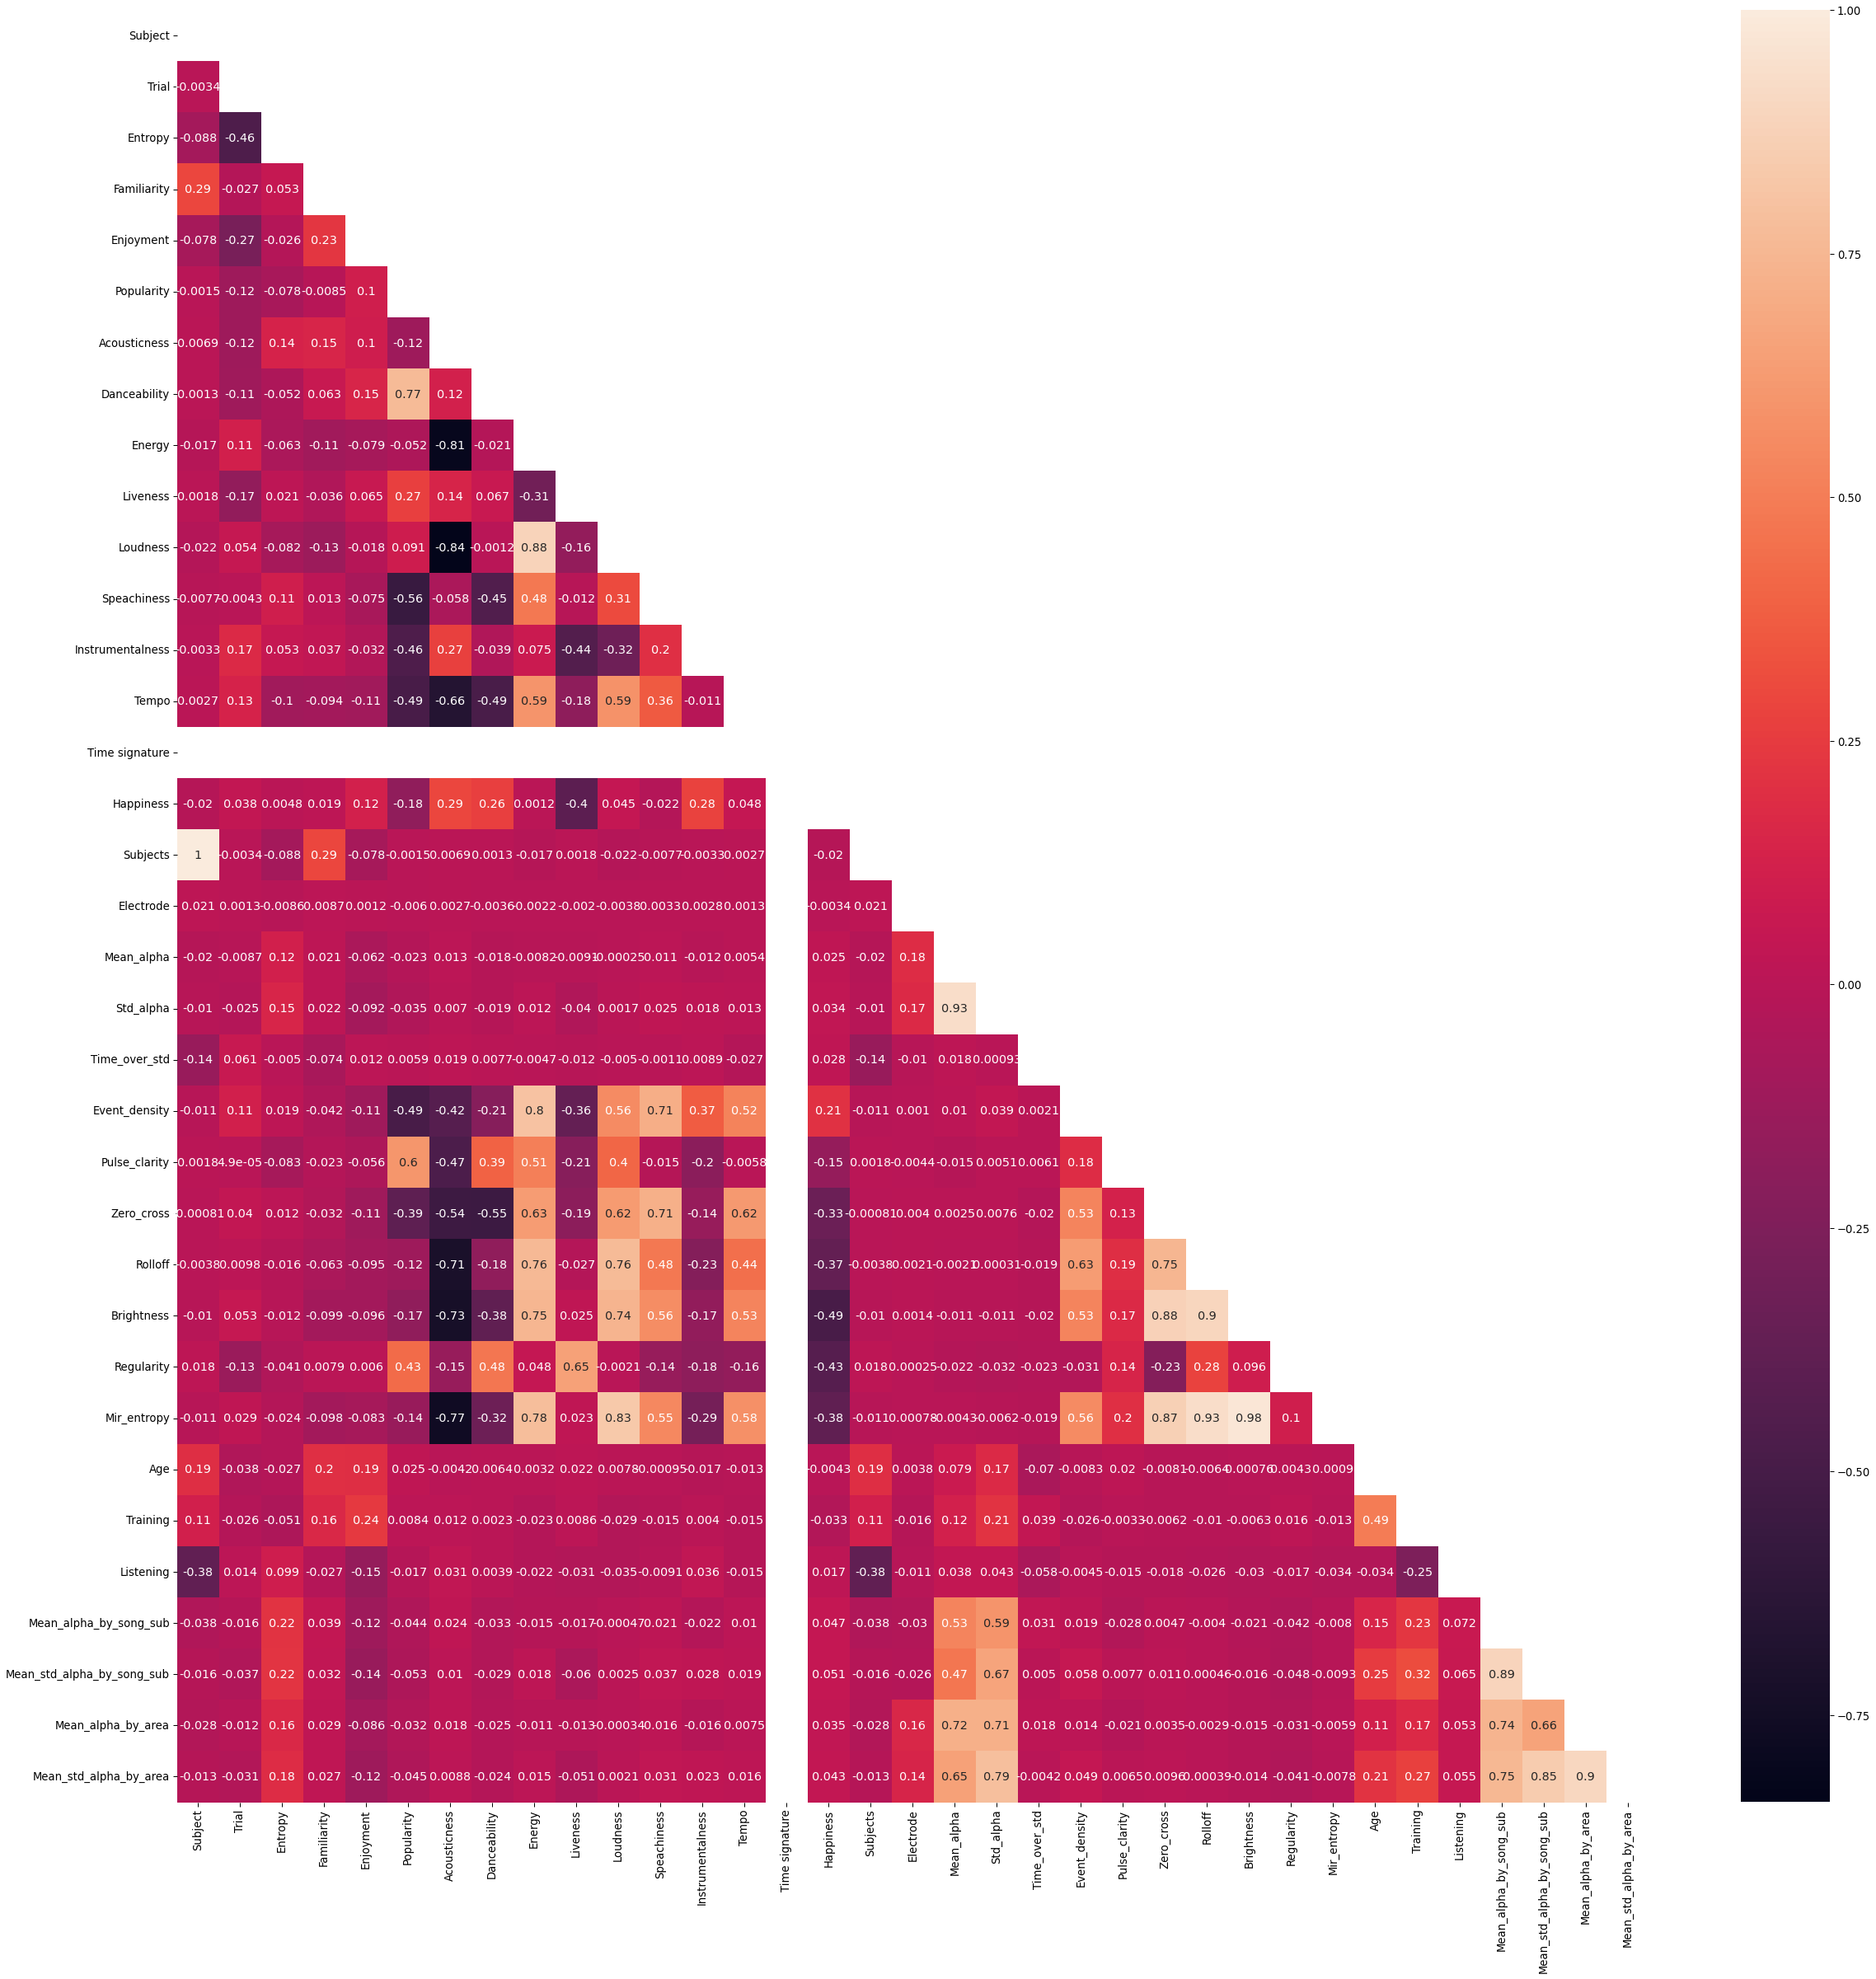

In [359]:
plt.figure(figsize = (40, 40))
sns.heatmap(data_sin_out.corr(), annot=True, mask=np.triu(data_sin_out.corr()));

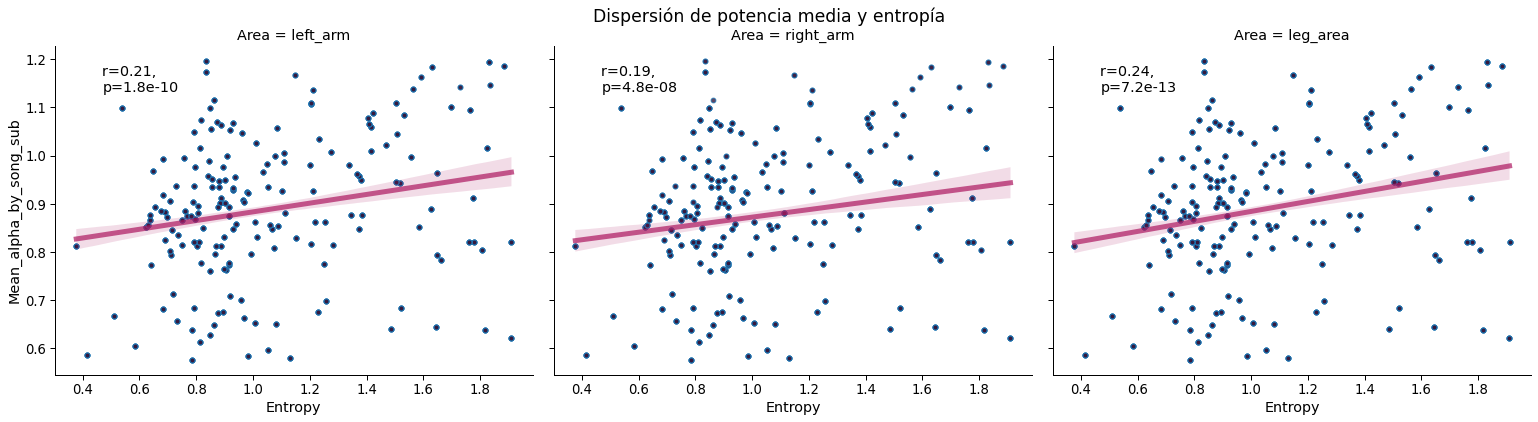

In [314]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_song_sub', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Area',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

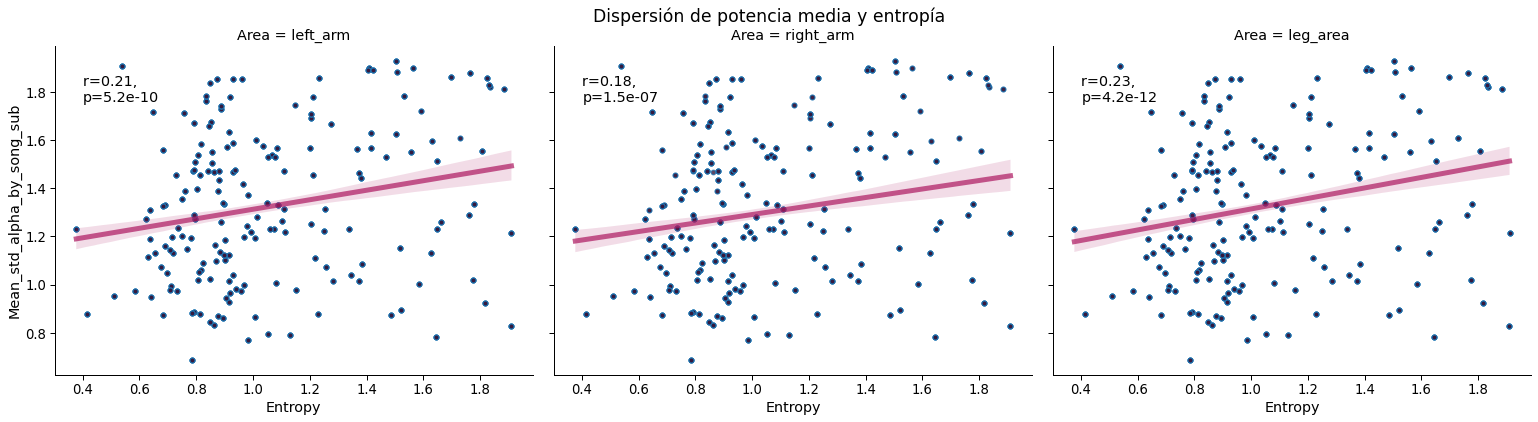

In [323]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_std_alpha_by_song_sub', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Area',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.06, .83, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

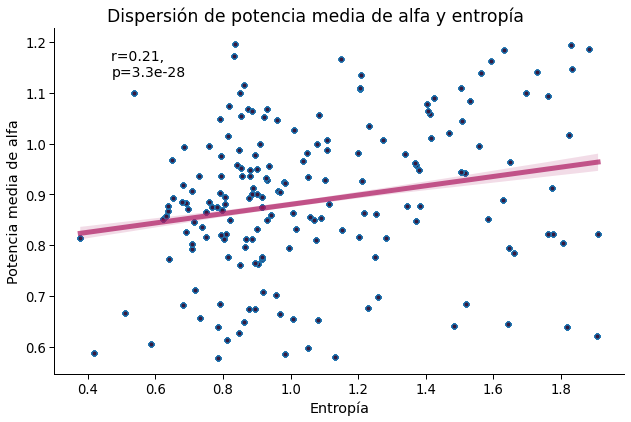

In [320]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_song_sub', 
               data = data_sin_out, 
               height = 6,
               aspect = 1.5,
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=14)
    

g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Dispersión de potencia media de alfa y entropía')
g.ax.set_xlabel('Entropía')
g.ax.set_ylabel('Potencia media de alfa')
g.savefig('Media de potencia y entropia.png');
plt.show();

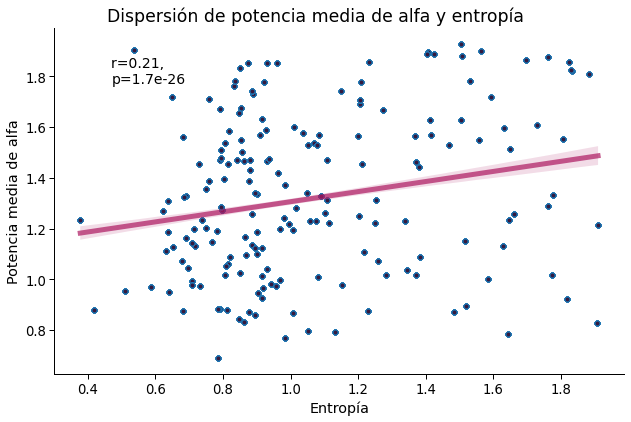

In [319]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_std_alpha_by_song_sub', 
               data = data_sin_out, 
               height = 6,
               aspect = 1.5,
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.1, .84, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=14)
    

g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Dispersión de potencia media de alfa y entropía')
g.ax.set_xlabel('Entropía')
g.ax.set_ylabel('Potencia media de alfa')
g.savefig('Media de potencia y entropia.png');
plt.show();

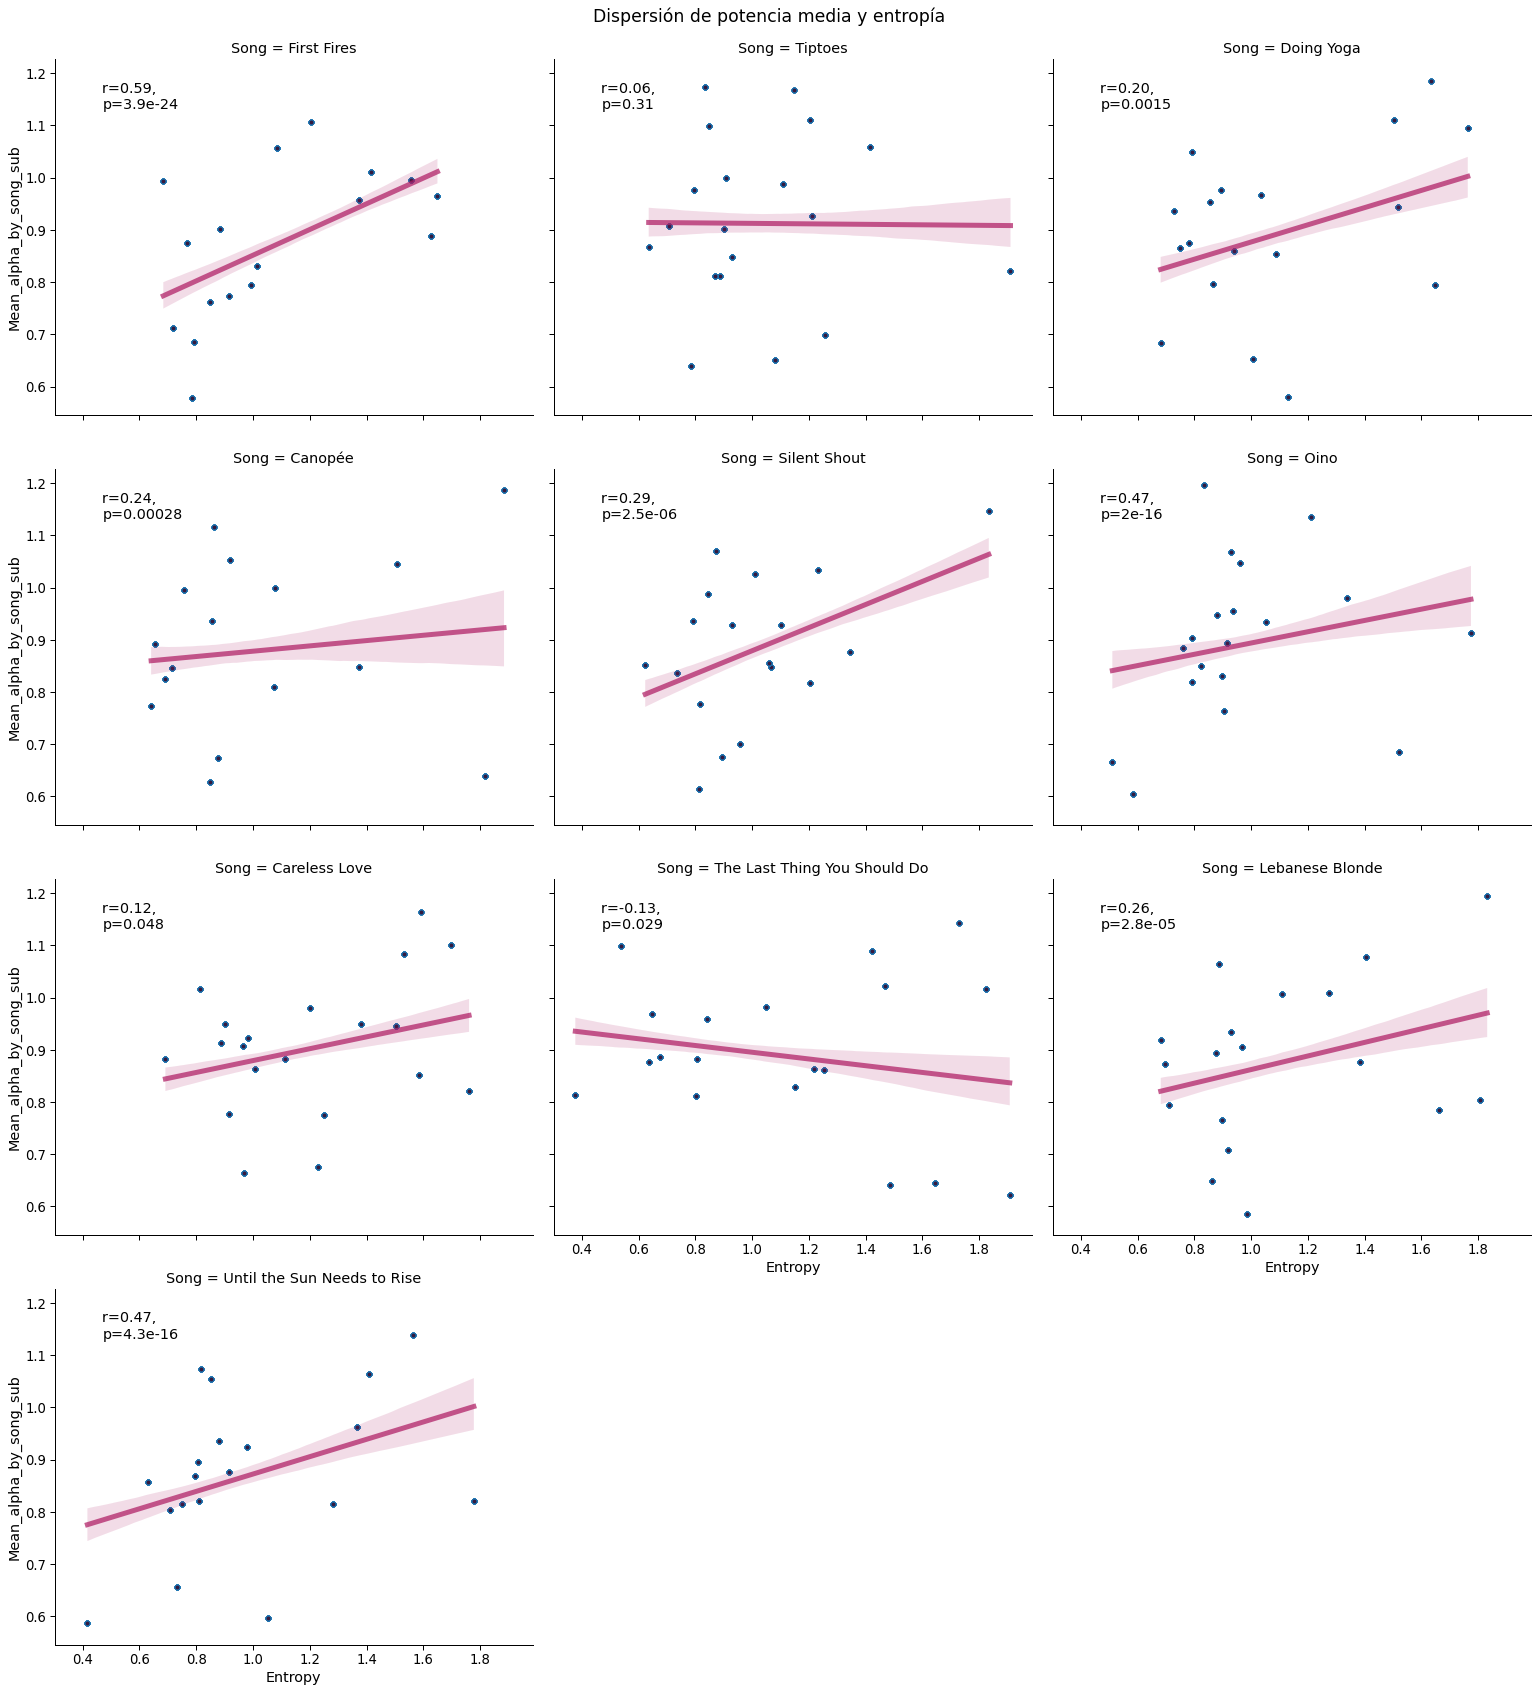

In [328]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_song_sub', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Song',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

Acá aparecen ya 7 relaciones con correlaciones interesante significativas con un alfa de .01. 

Los temas son First Fires, Doing Yoga, Canopée, Silent Shout, Oino, Lebanese Blonde y Until the Sun Need to Rise.

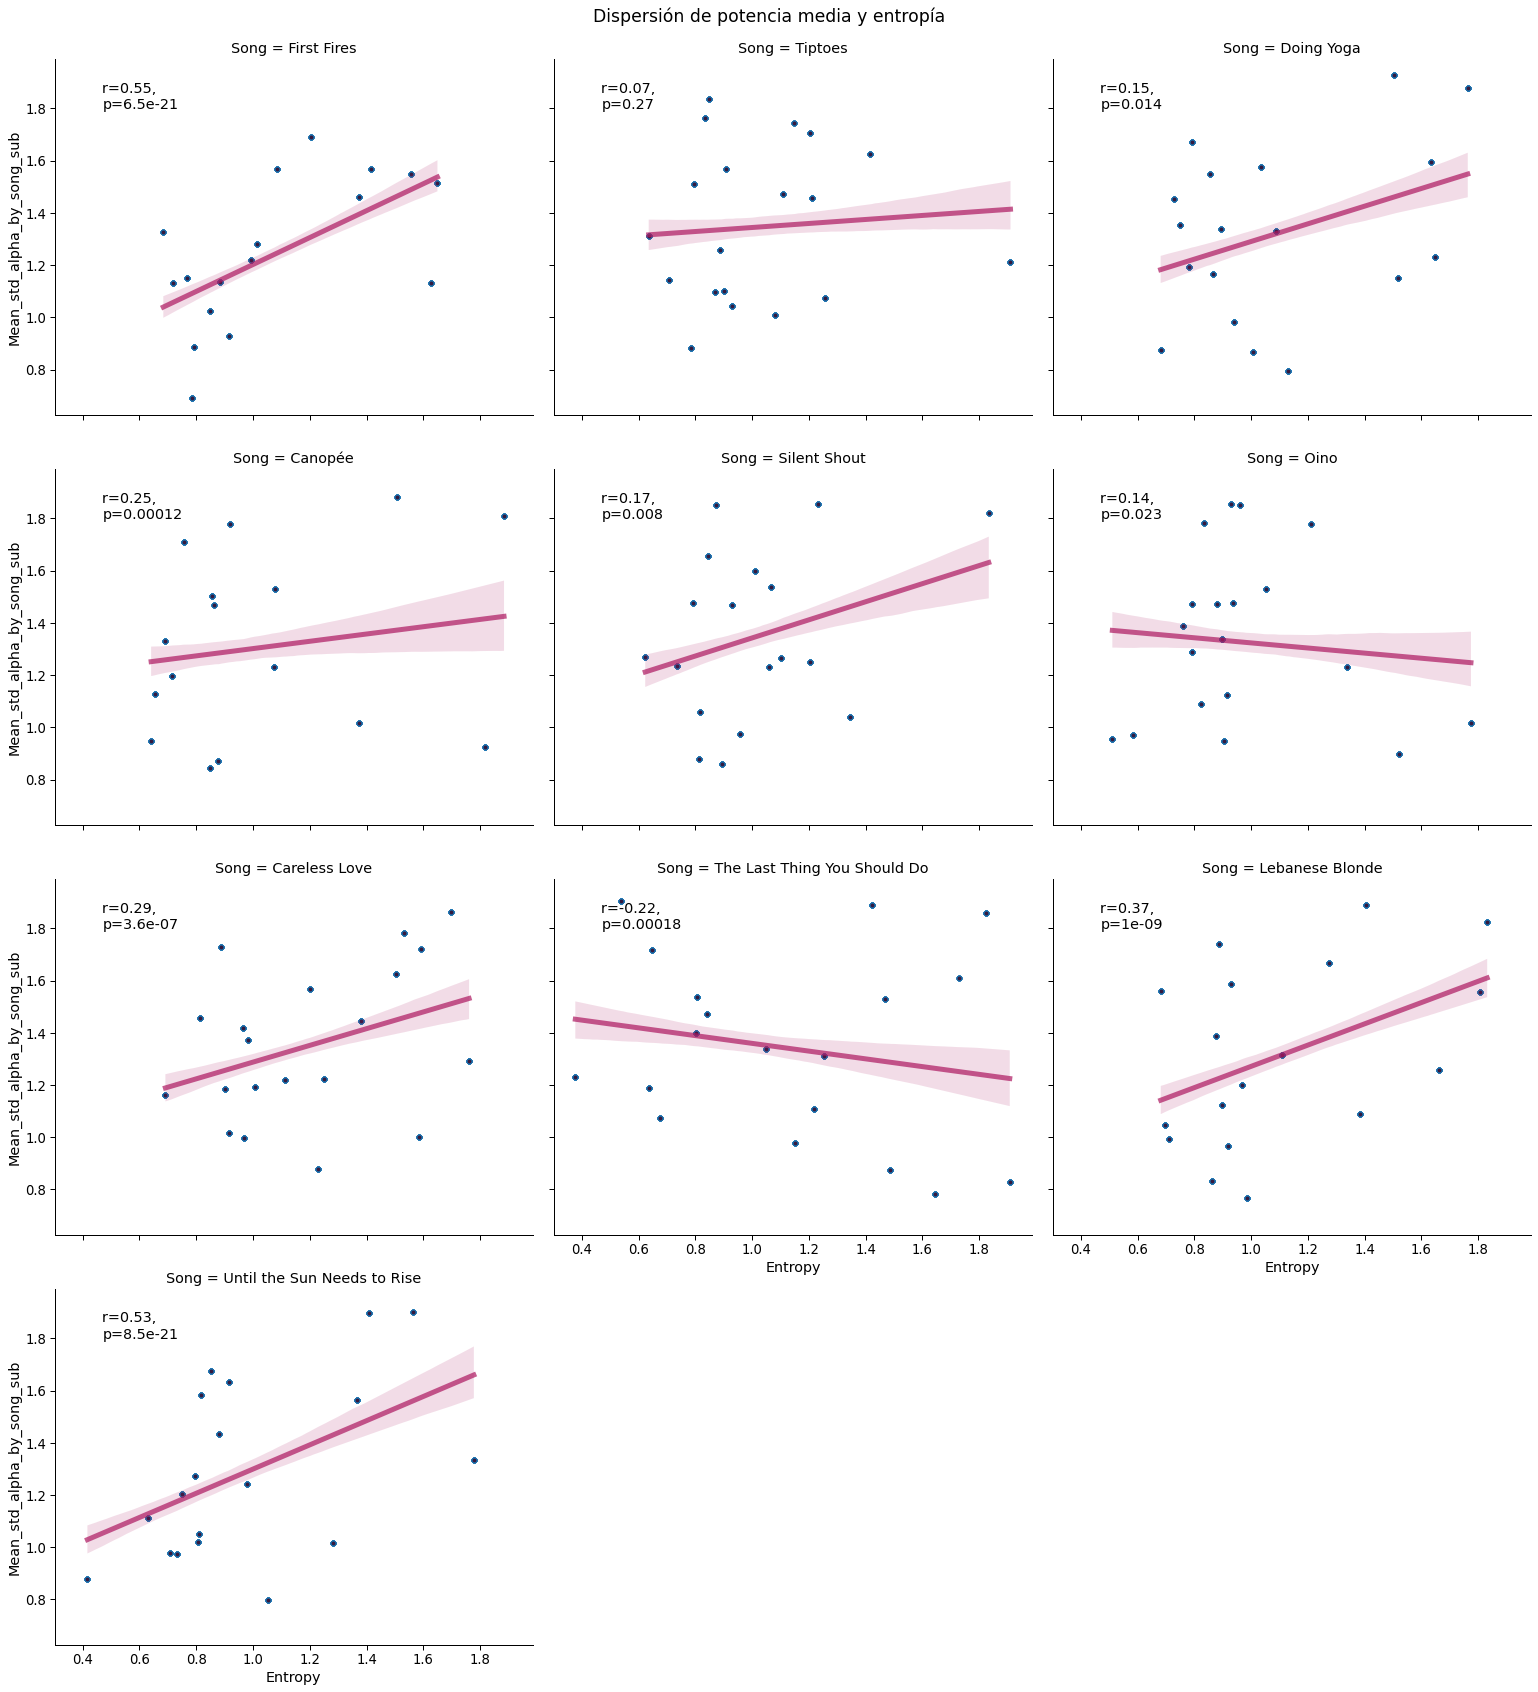

In [329]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_std_alpha_by_song_sub', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Song',
               col = 'Song',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_song_sub'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Dispersión de potencia media y entropía')
#g.axes.xlabel('Entropía')
#g.axes.ylabel('Desvío de alfa')
plt.show();

Acá hay 6 significativas con alfa de .01:
    
First Fires, Canopée, Silent Shout, Careless Love, Lebanese Blonde y Until the Sun Need to Rise.

Tanto en el anterior aparece una correlación negativa significativa para The Last Thing You Should Do, habría que explorar qué tiene ese tema.

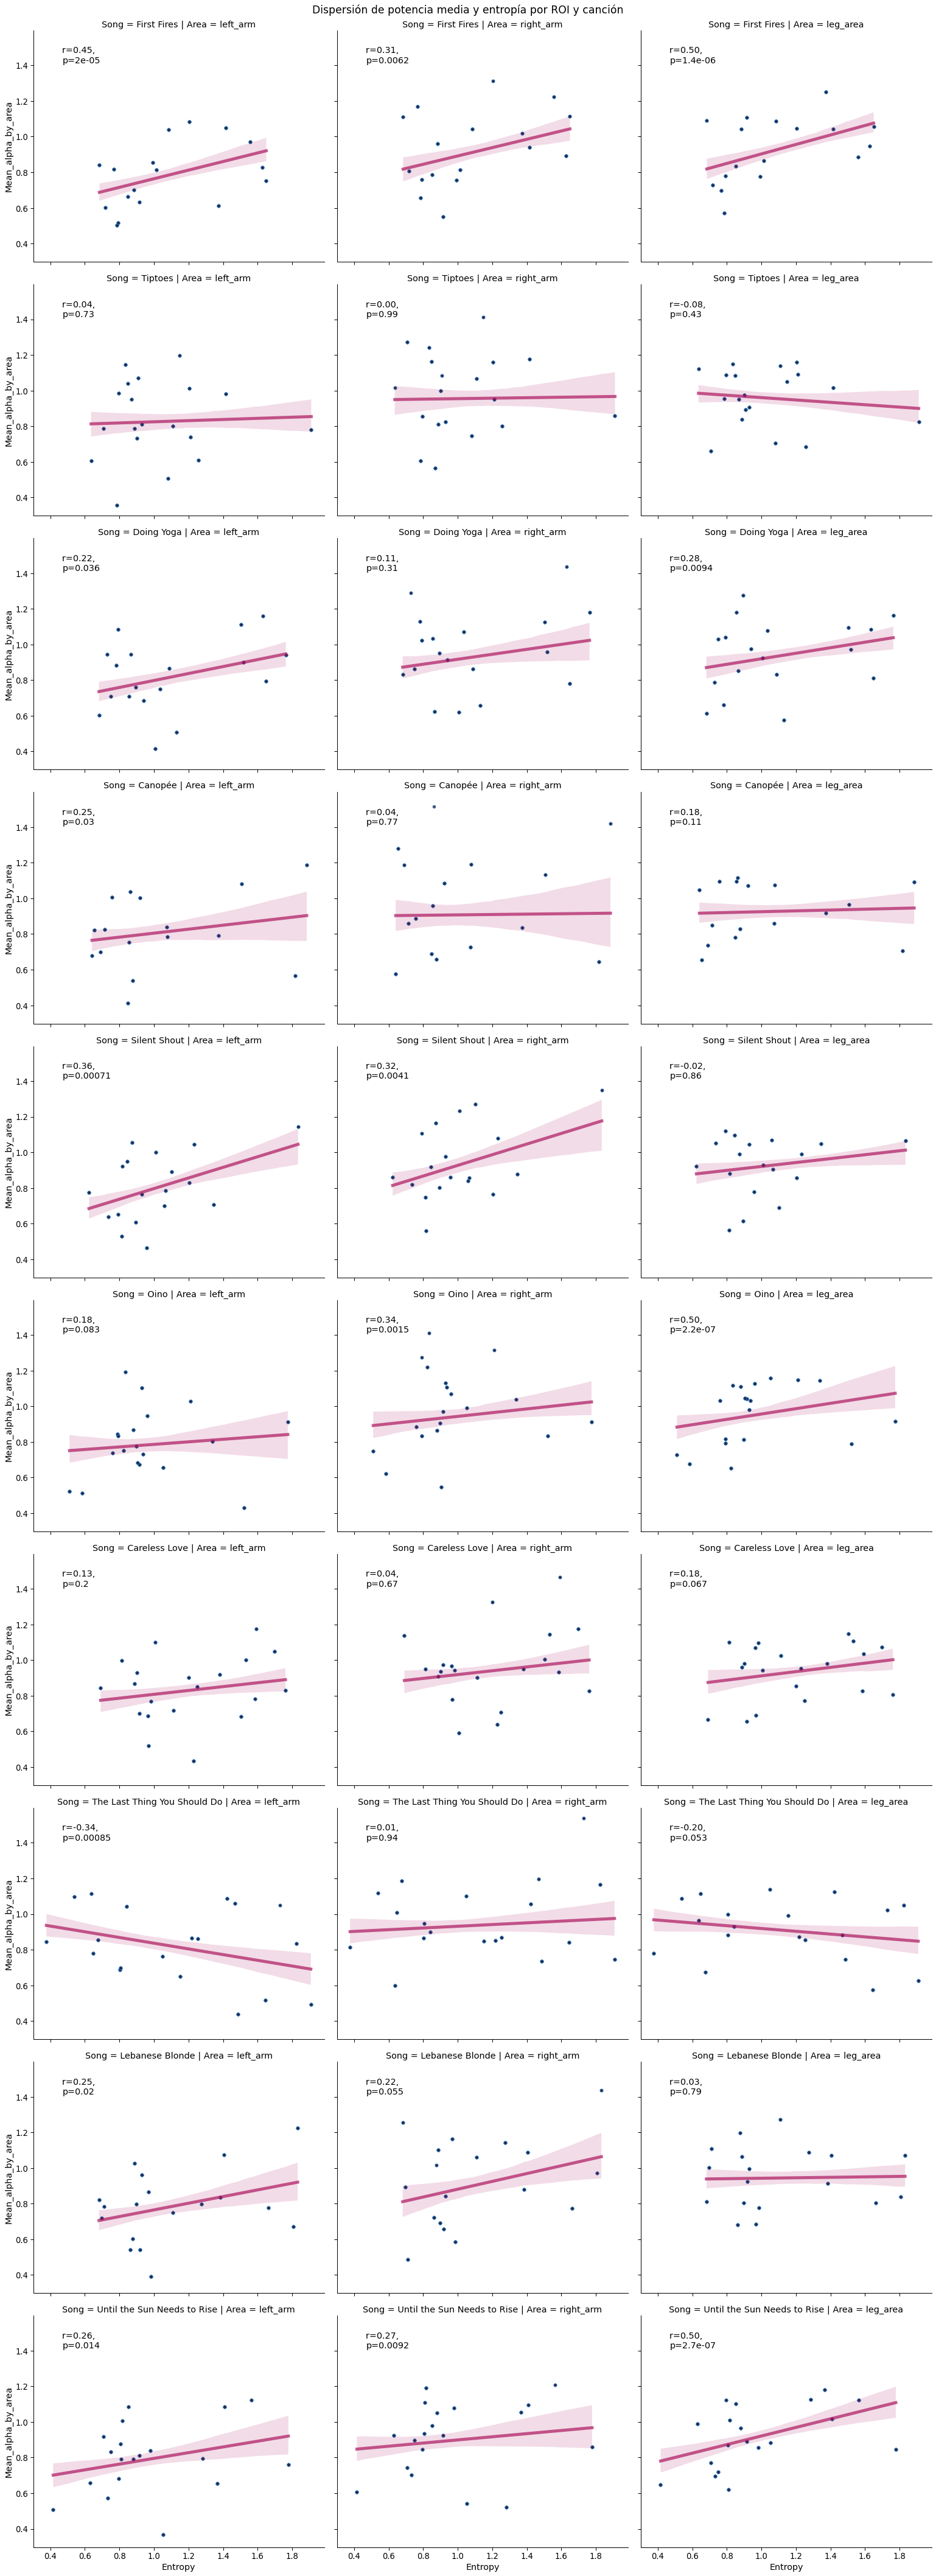

In [345]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               row = 'Song',
               col = 'Area',
               #col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Dispersión de potencia media y entropía por ROI y canción')
plt.show();

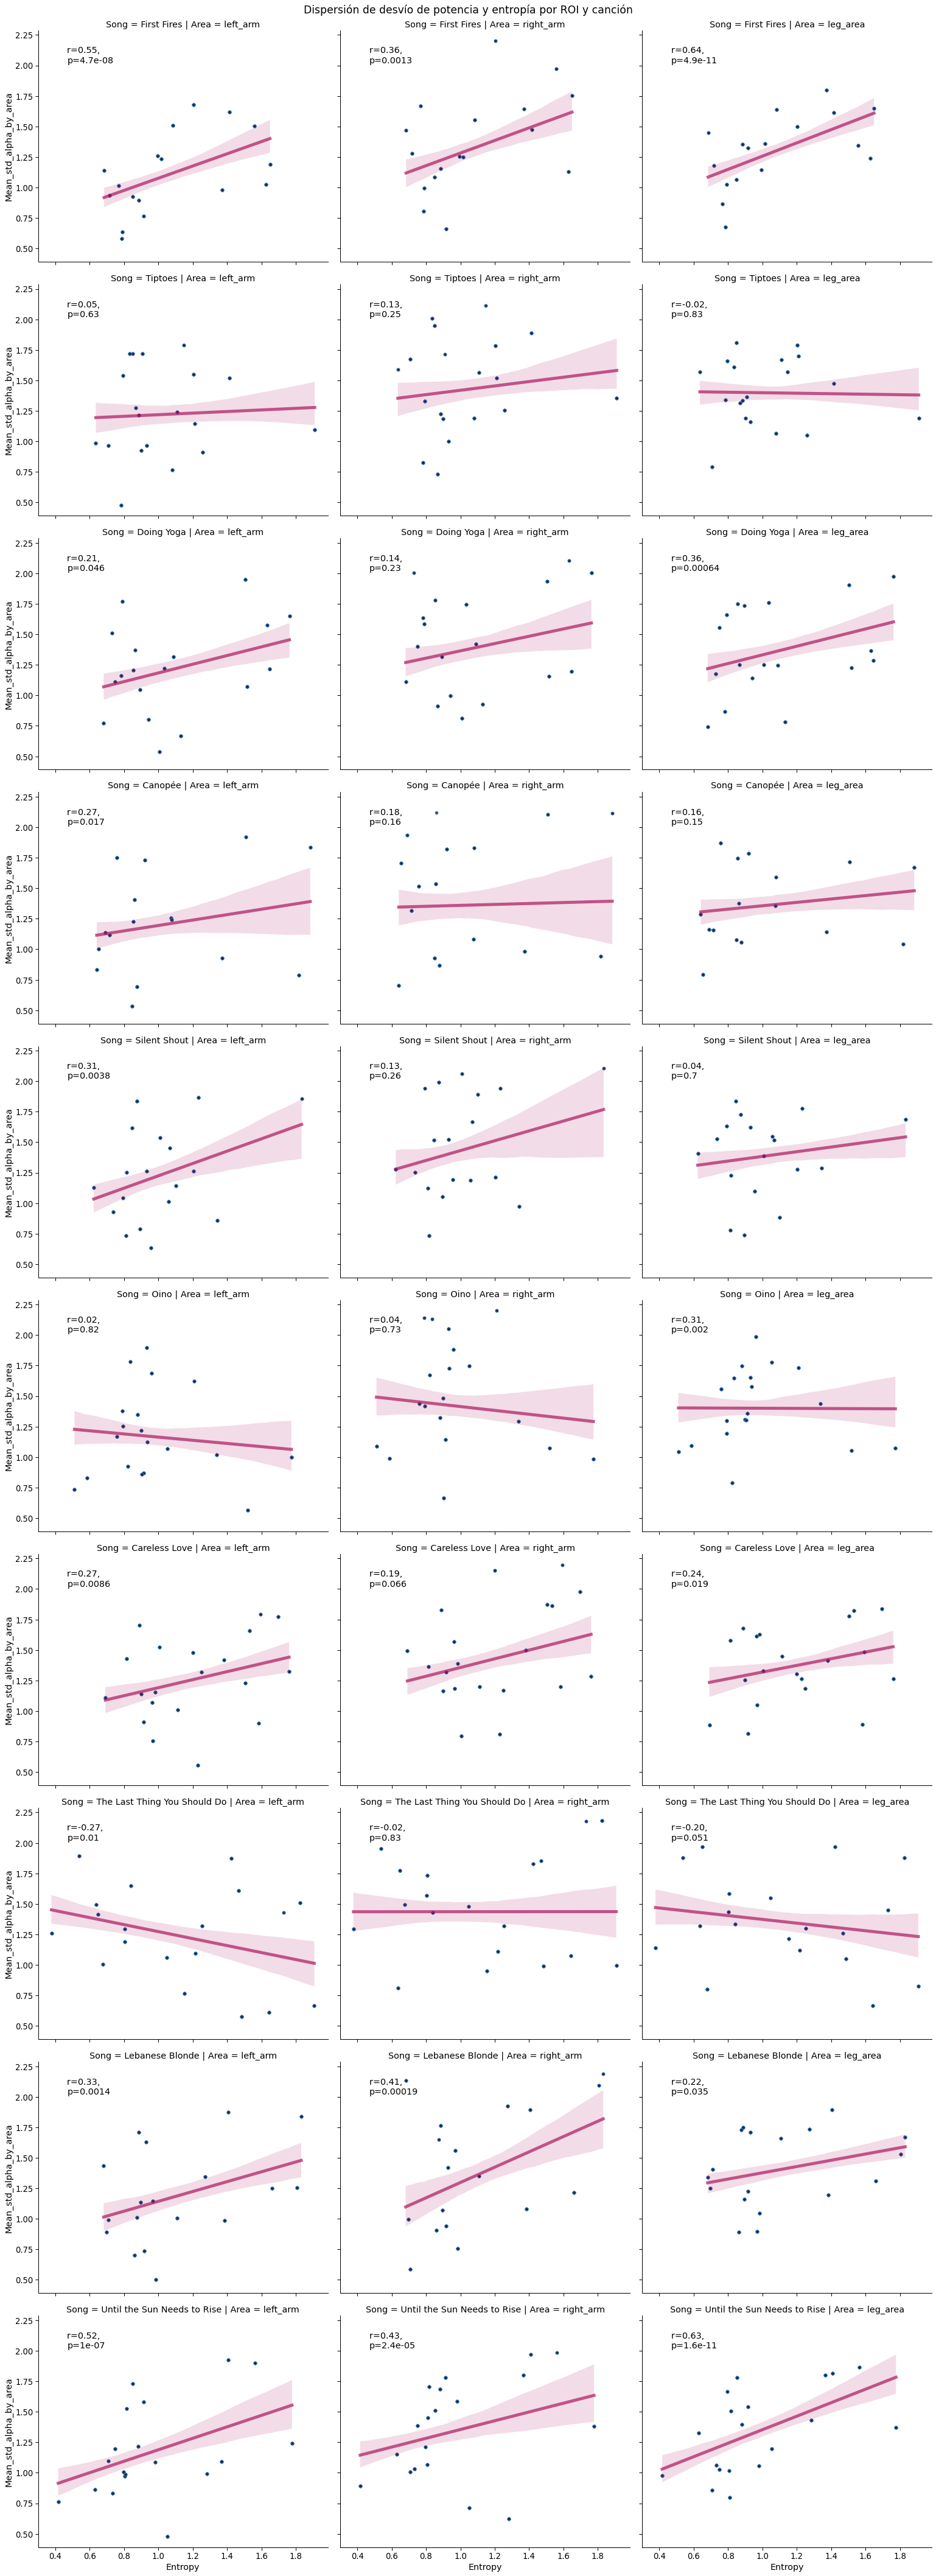

In [346]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_std_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               row = 'Song',
               col = 'Area',
               #col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Dispersión de desvío de potencia y entropía por ROI y canción')
plt.show();

Acá aparecen correlaciones significativas para 5 o 6canciones que varían un poco dependiendo de la métrica. 

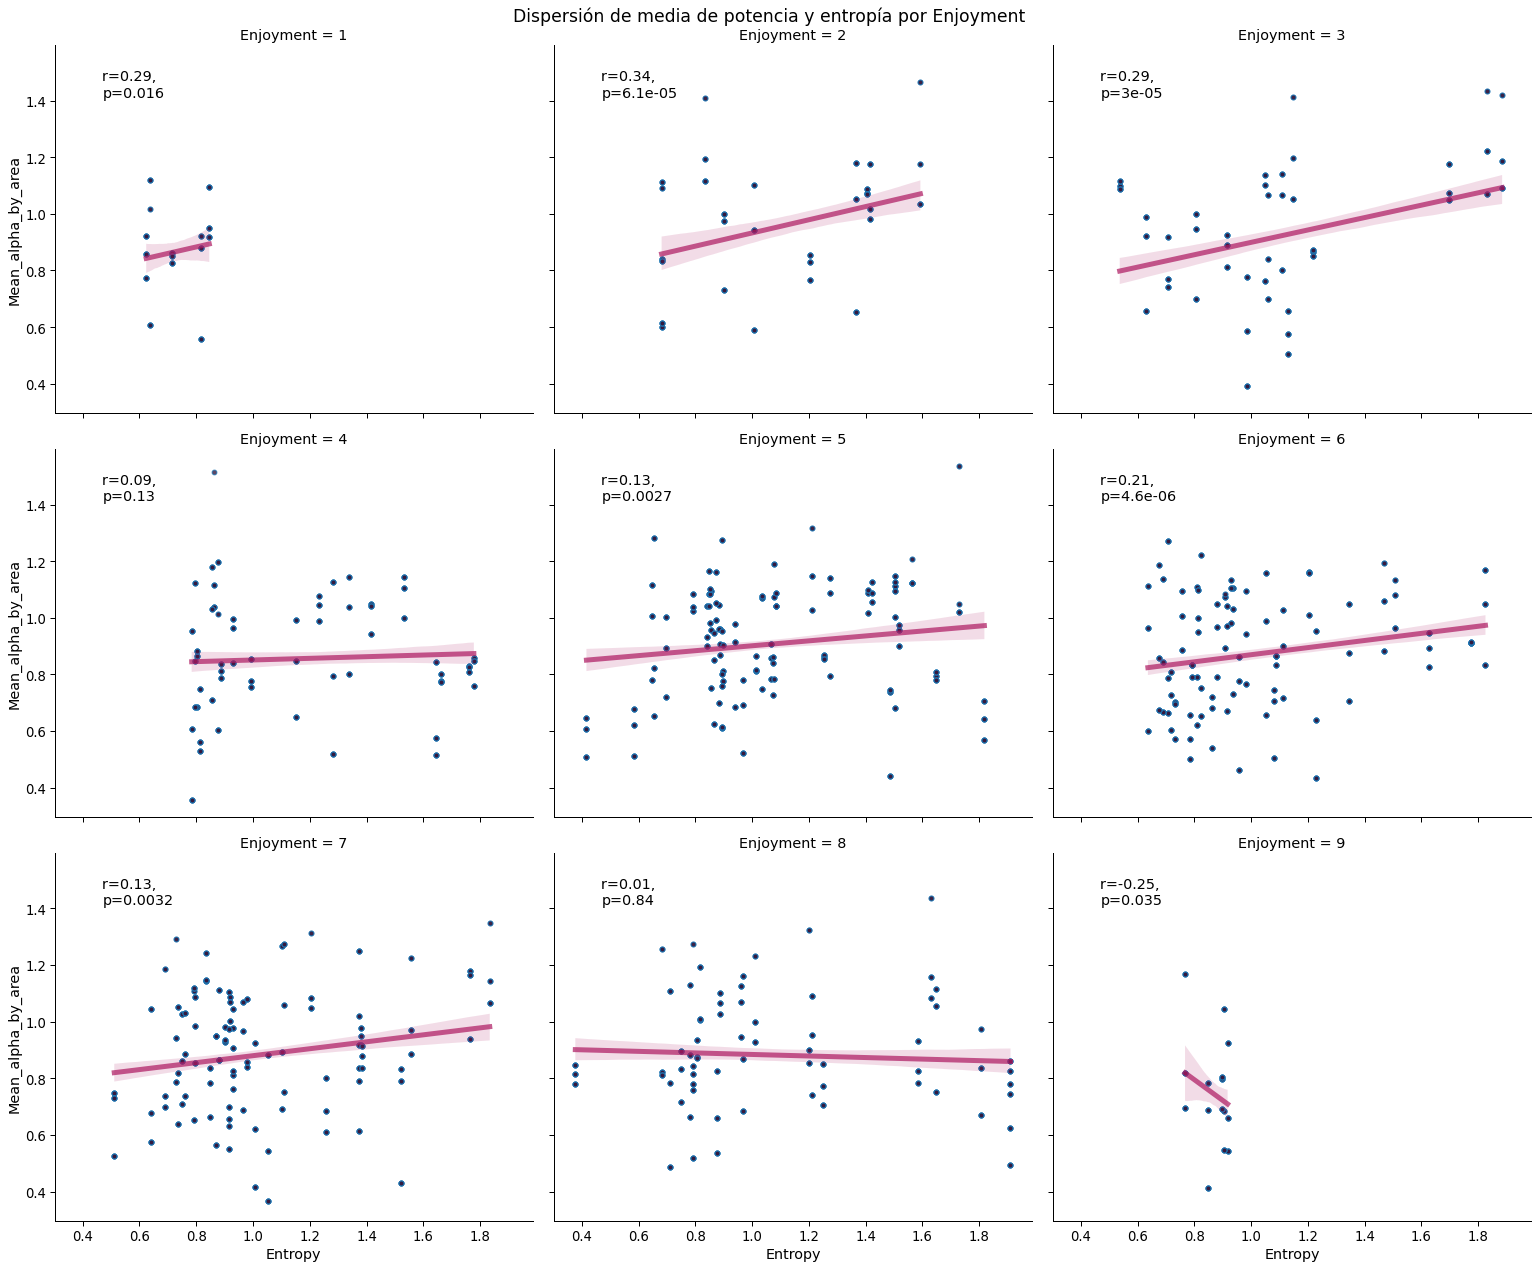

In [349]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Enjoyment',
               col = 'Enjoyment',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Dispersión de media de potencia y entropía por Enjoyment')
plt.show();

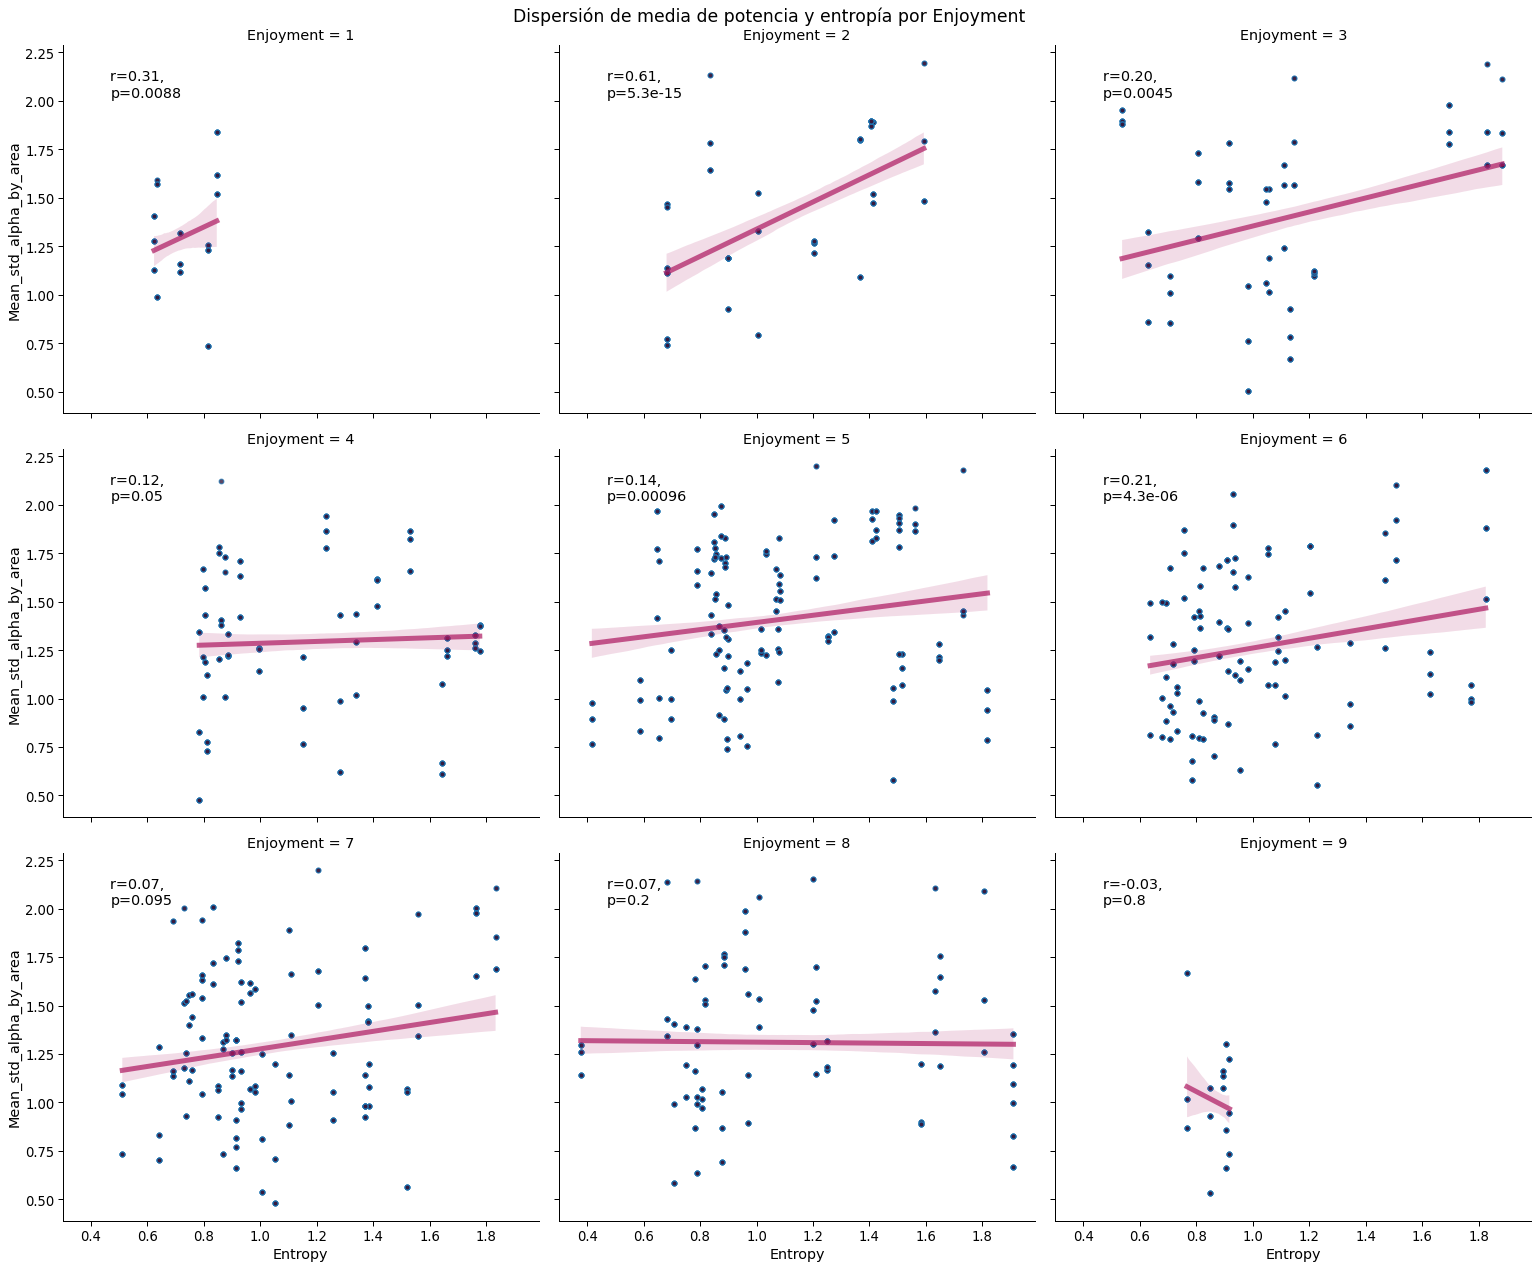

In [350]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_std_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Enjoyment',
               col = 'Enjoyment',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_std_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Dispersión de media de potencia y entropía por Enjoyment')
plt.show();

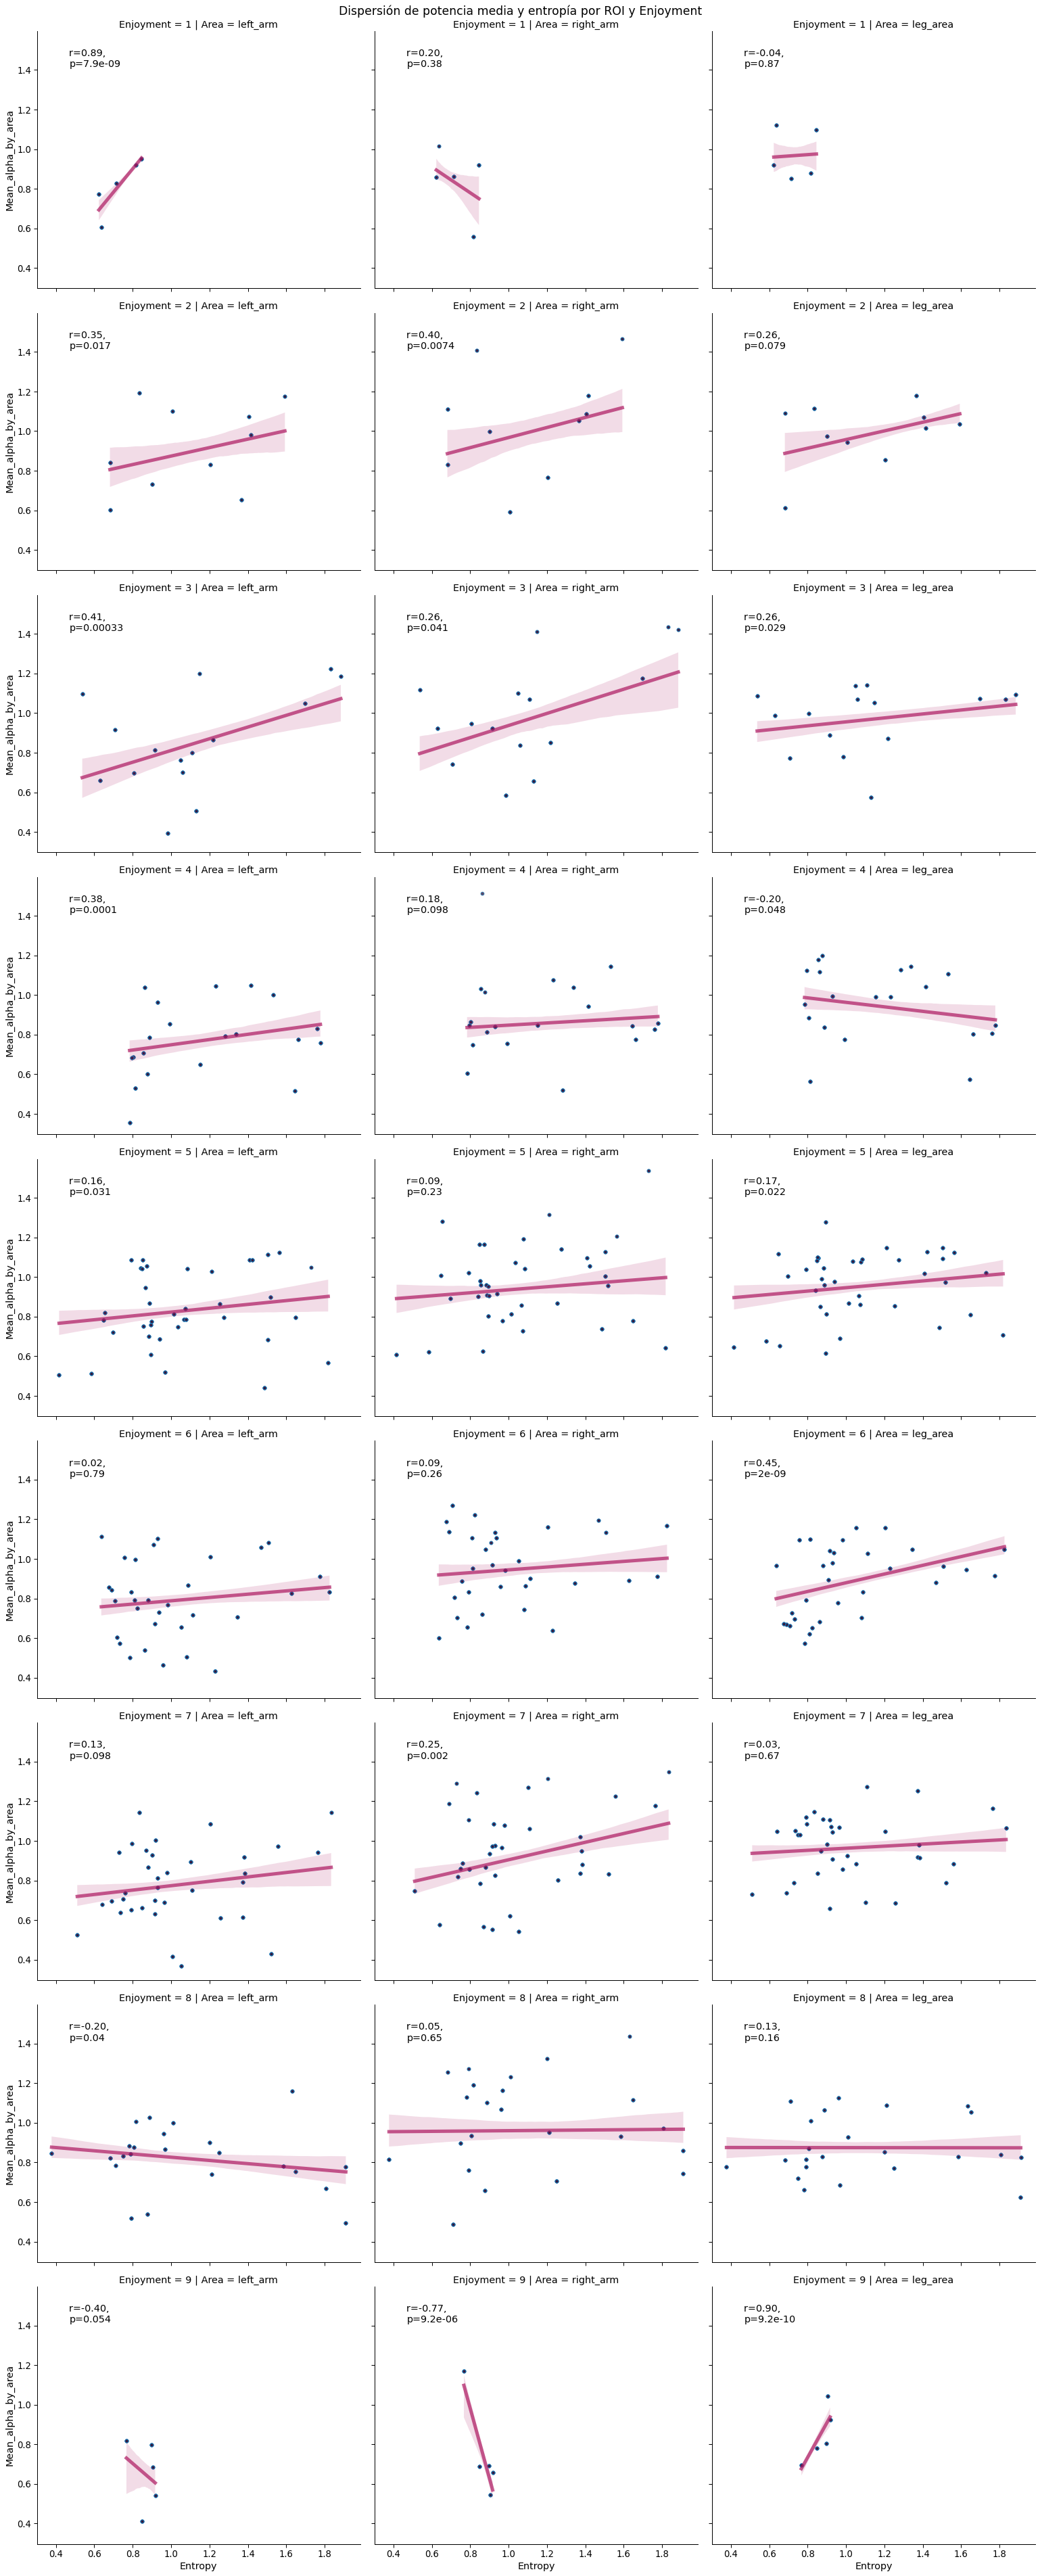

In [353]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               row = 'Enjoyment',
               col = 'Area',
               #col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Dispersión de potencia media y entropía por ROI y Enjoyment')
plt.show();

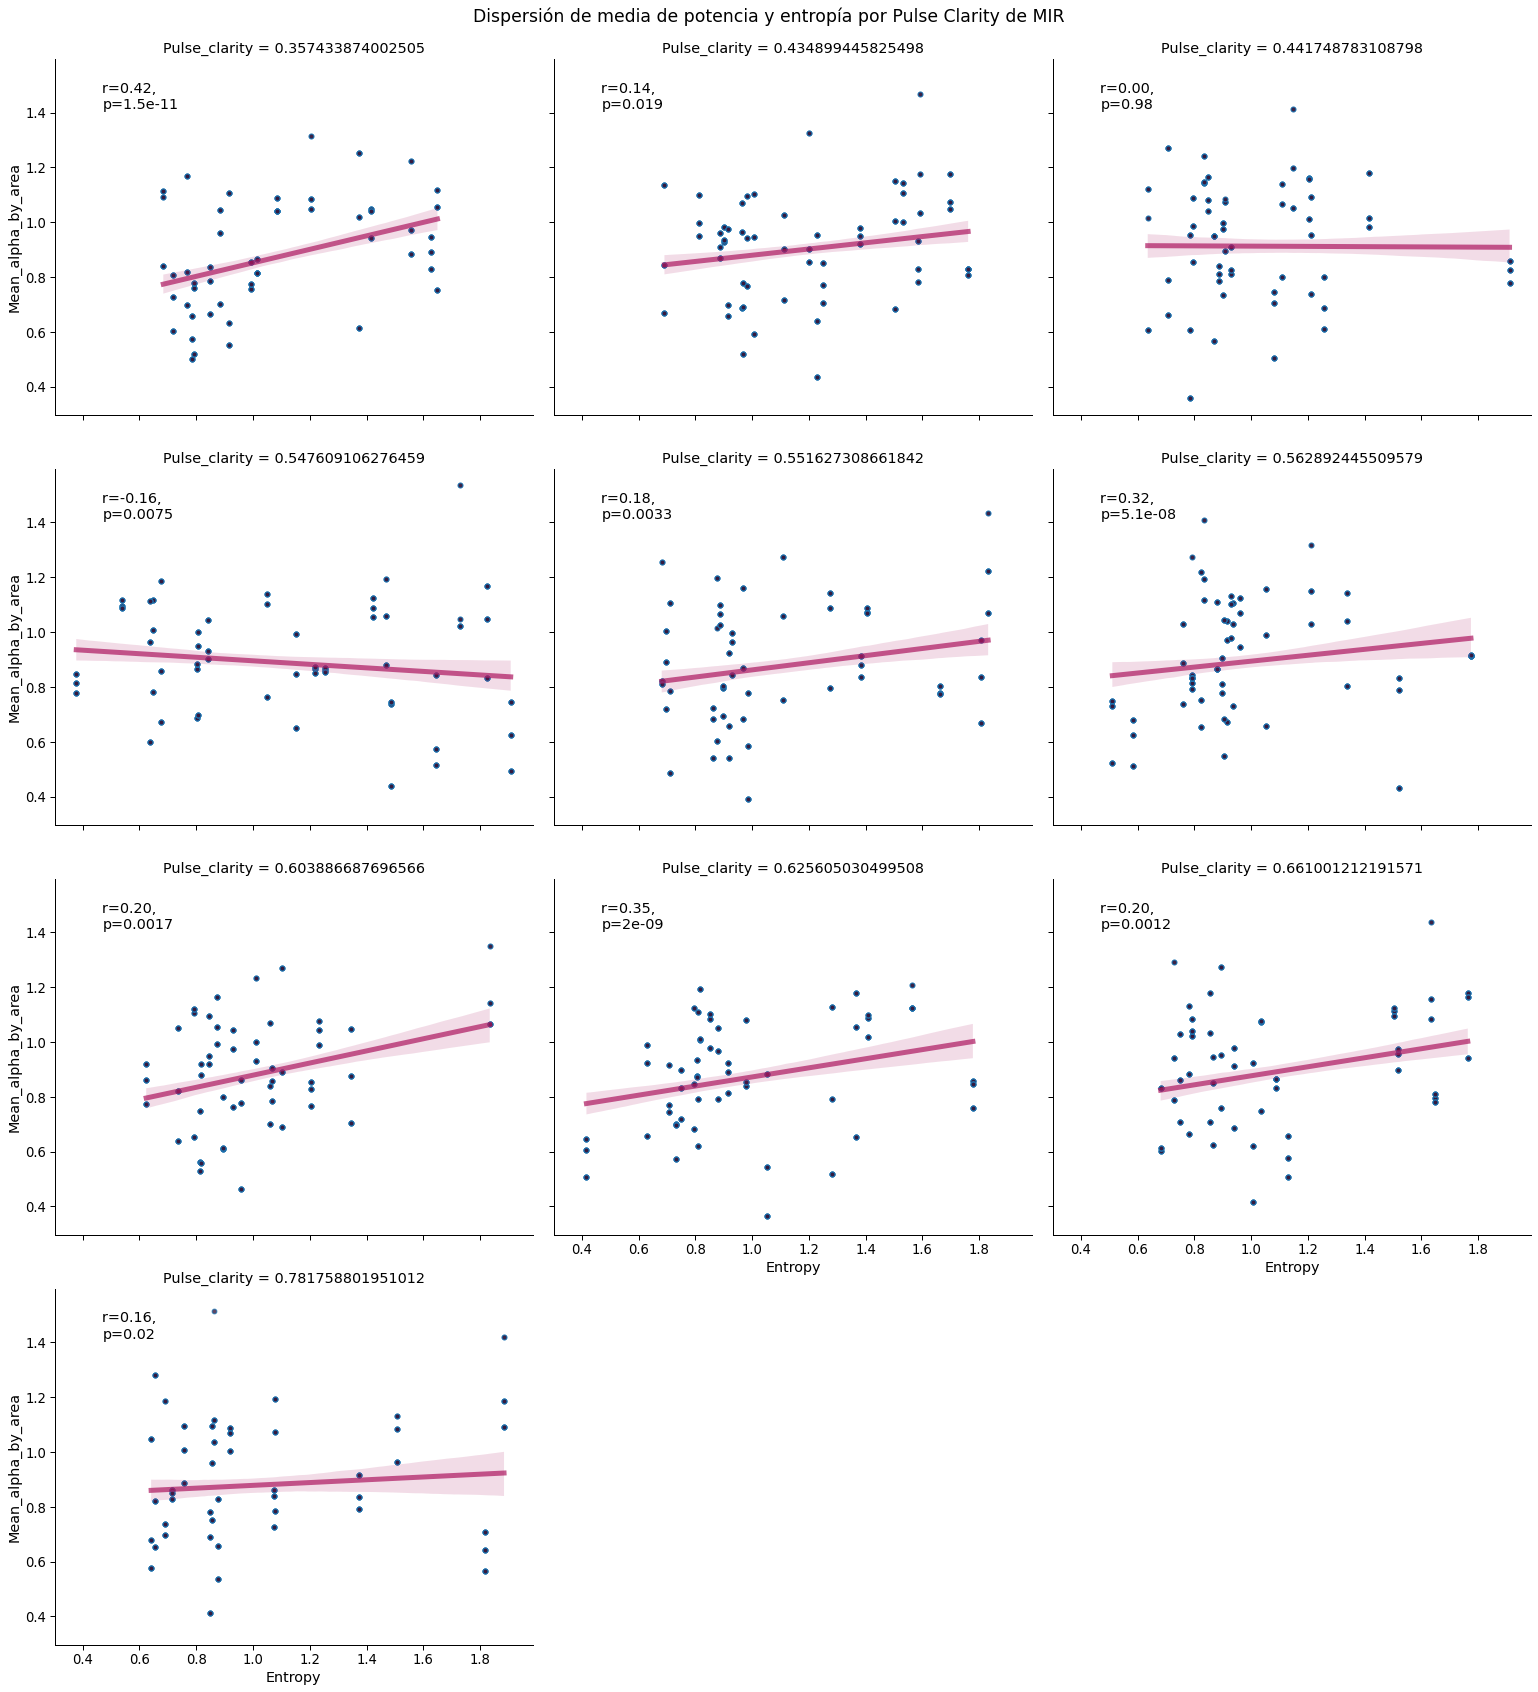

In [354]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               #row = 'Enjoyment',
               col = 'Pulse_clarity',
               col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Dispersión de media de potencia y entropía por Pulse Clarity de MIR')
plt.show();

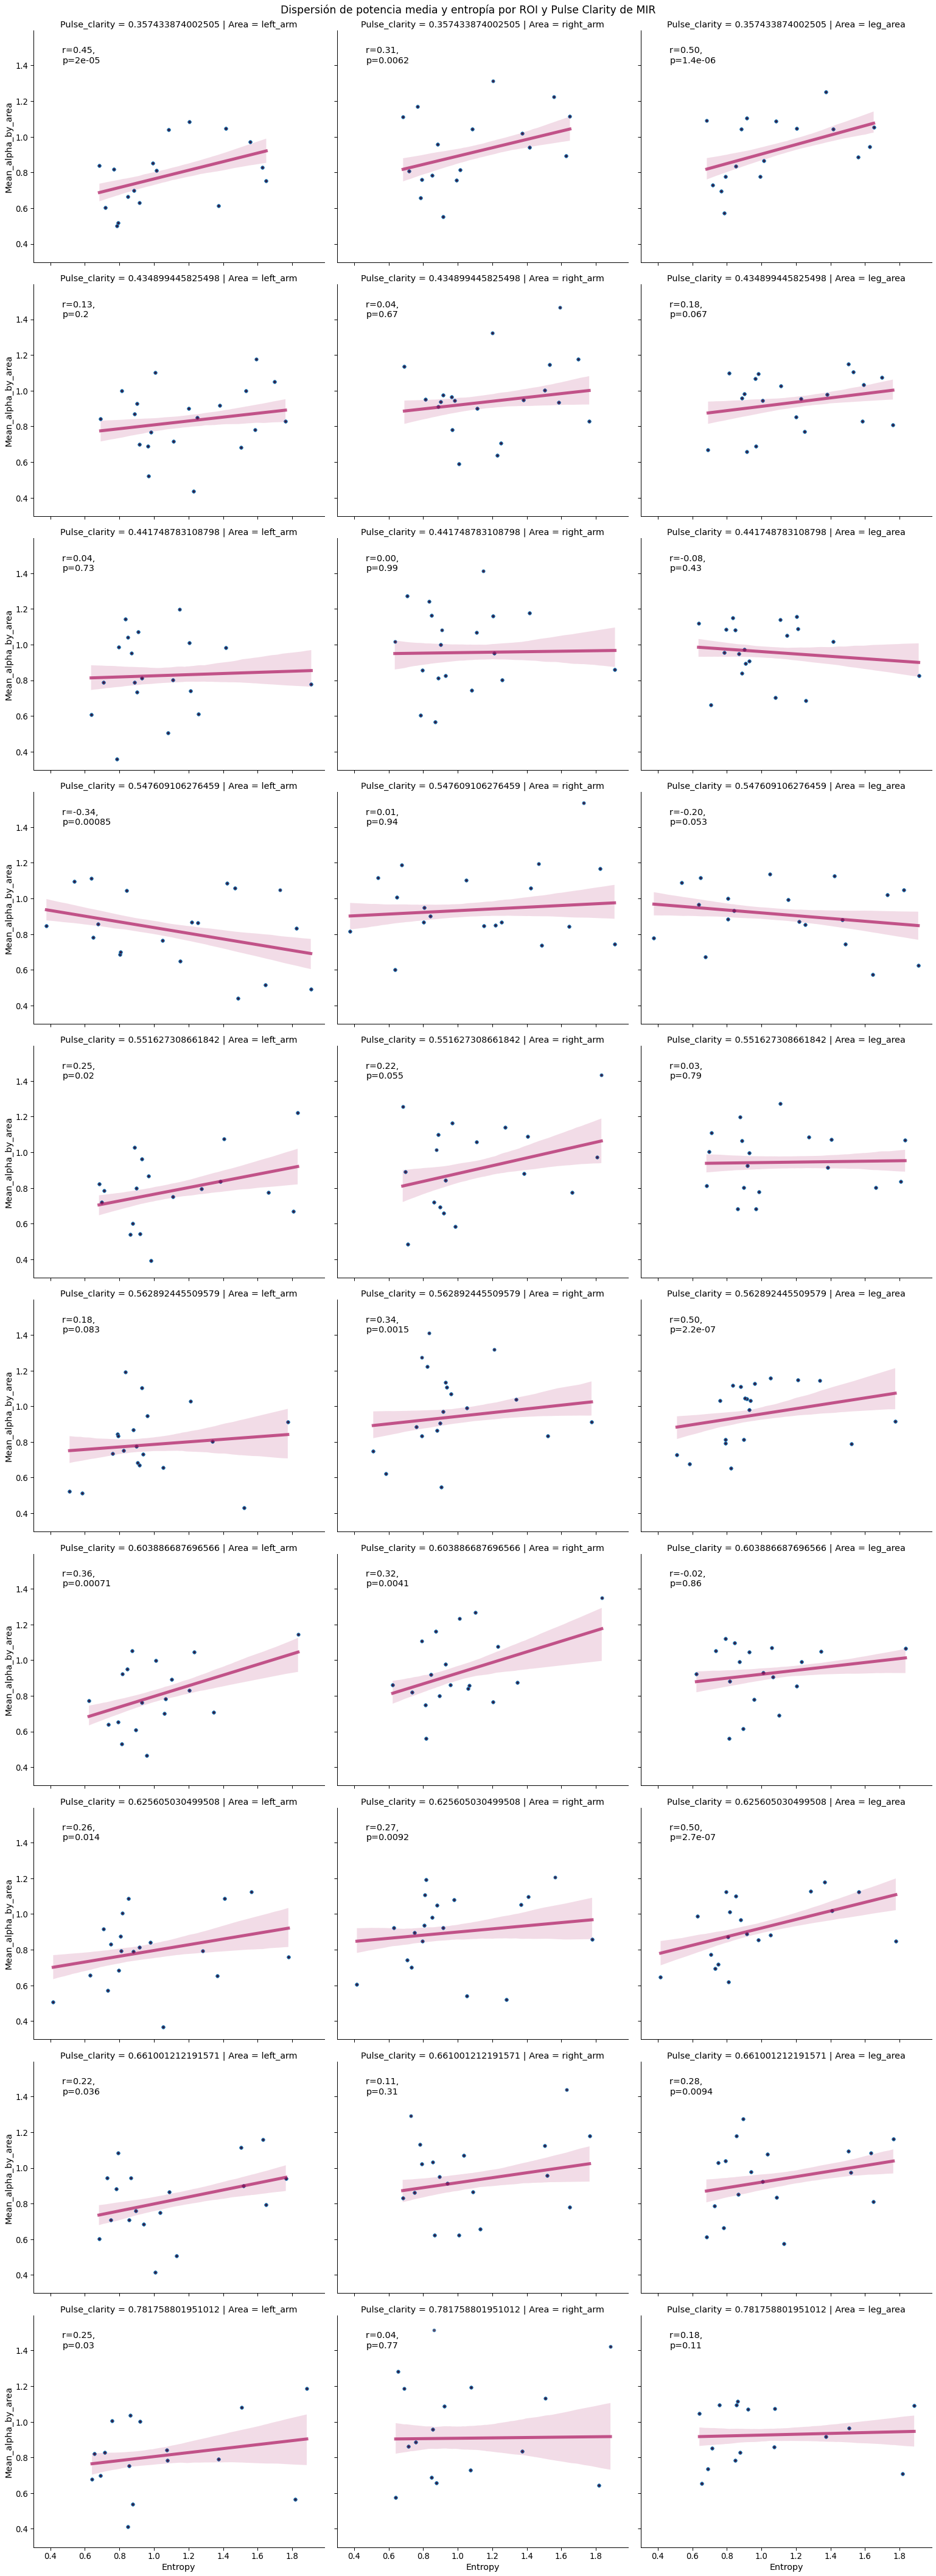

In [355]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               row = 'Pulse_clarity',
               col = 'Area',
               #col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Dispersión de potencia media y entropía por ROI y Pulse Clarity de MIR')
plt.show();

In [ ]:
g = sns.lmplot(x ='Entropy', 
               y ='Mean_alpha_by_area', 
               data = data_sin_out,
               height = 6,
               aspect = 1.2,
               row = 'Event_density',
               col = 'Area',
               #col_wrap = 3,
               palette = 'rocket',
               line_kws={"color": '#ad1760', "alpha":0.7,"lw":5},
               scatter_kws = {'facecolors': '#35193e'}
              )

def annotate(data, **kws):
    r, p = stats.spearmanr(data['Entropy'], data['Mean_alpha_by_area'])
    ax = plt.gca()
    ax.text(.1, .86, 'r={:.2f}, \np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Dispersión de potencia media y entropía por ROI y Event Density de MIR')
plt.show();